## Libraries utilisées

In [1]:
# Imports pour la manipulation des données
import io
import requests
import numpy as np
import pandas as pd

# Imports pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Imports pour les tests statistiques et les mesures de performance
from scipy.stats import chi2_contingency, spearmanr, stats, ttest_ind, pointbiserialr
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Imports pour la prétraitement des données
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler

# Imports pour la sélection du modèle et l'évaluation
from sklearn.model_selection import (
    learning_curve, train_test_split, cross_val_score, GridSearchCV
)

# Imports pour les modèles classificateurs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Imports spécifiques à TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor

## Importation des données

In [2]:
url = "https://raw.githubusercontent.com/ElieCht/SVM-RN-Lou-Ann-Elie/main/heart_2020_cleaned.csv"
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')
df.sample(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
130360,No,21.53,Yes,No,No,10.0,30.0,No,Female,75-79,White,No,Yes,Good,7.0,No,No,Yes
60177,No,33.00,No,No,No,0.0,2.0,No,Male,30-34,White,No,Yes,Very good,7.0,Yes,No,No
295717,No,31.32,No,No,No,8.0,10.0,No,Male,18-24,White,No,Yes,Very good,7.0,No,No,No
240609,No,21.46,No,No,No,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,8.0,No,No,No
266235,No,34.70,No,No,No,0.0,0.0,No,Male,45-49,Hispanic,No,Yes,Excellent,9.0,No,No,No
96492,No,29.05,No,No,No,0.0,2.0,No,Female,50-54,White,No,Yes,Very good,7.0,No,No,No
86224,No,27.44,No,No,No,0.0,0.0,No,Female,50-54,White,No,No,Very good,7.0,No,No,No
303280,No,27.02,No,No,No,2.0,1.0,No,Female,55-59,White,No,Yes,Very good,7.0,No,No,No
73633,No,35.26,No,No,No,0.0,0.0,No,Male,60-64,White,"No, borderline diabetes",Yes,Very good,7.0,Yes,No,No
15603,No,32.89,No,No,No,30.0,30.0,Yes,Male,60-64,White,No,No,Fair,6.0,No,No,No


On constate déjà que le nom des variables est correcte puisqu'ils sont assez explicits et ne contiennent pas d'espaces ou d'apostrophes : nous n'aurons pas à les renommer.

### I - Analyse exploratoire

#### I.1 - Statistiques univariées

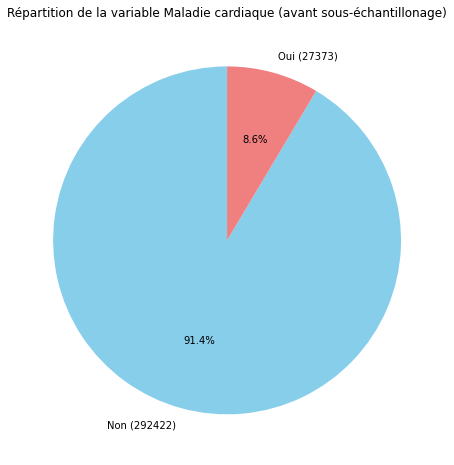

In [3]:
# Compter le nombre d'occurrences de chaque catégorie
counts = df['HeartDisease'].value_counts()

# Calculer les pourcentages pour chaque catégorie
percentage_values = counts / counts.sum() * 100

# Créer un graphique en secteurs (pie plot) avec des pourcentages et le nombre d'occurrences
plt.figure(figsize=(8, 8))
plt.pie(percentage_values, labels=[f'Non ({counts["No"]})', f'Oui ({counts["Yes"]})'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Répartition de la variable Maladie cardiaque (avant sous-échantillonage)')
plt.show()

On constate que la variable est très déséquilibrée. La classe minoritaire correspond aux personnes ont fait une attaque cardiaque. Autrement dit, le dataset est constitué d'une majorité de personnes n'ayant pas subies de maladies cardiaques. Il faudra effecter un ré-échantillonage par la suite.

#### I.1 - Statistiques descriptives

In [5]:
df.describe(include='all')

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795,319795.000000,319795,319795,319795,319795.00000,319795.000000,319795,319795,319795,319795,319795,319795,319795,319795.000000,319795,319795,319795
unique,2,NaN,2,2,2,NaN,NaN,2,2,13,6,4,2,5,NaN,2,2,2
top,No,NaN,No,No,No,NaN,NaN,No,Female,65-69,White,No,Yes,Very good,NaN,No,No,No
freq,292422,NaN,187887,298018,307726,NaN,NaN,275385,167805,34151,245212,269653,247957,113858,NaN,276923,308016,289976
mean,NaN,28.325399,NaN,NaN,NaN,3.37171,3.898366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097075,NaN,NaN,NaN
std,NaN,6.356100,NaN,NaN,NaN,7.95085,7.955235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436007,NaN,NaN,NaN
min,NaN,12.020000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,24.030000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
50%,NaN,27.340000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN
75%,NaN,31.420000,NaN,NaN,NaN,2.00000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN


#### I.2 - Statistiques bivariées

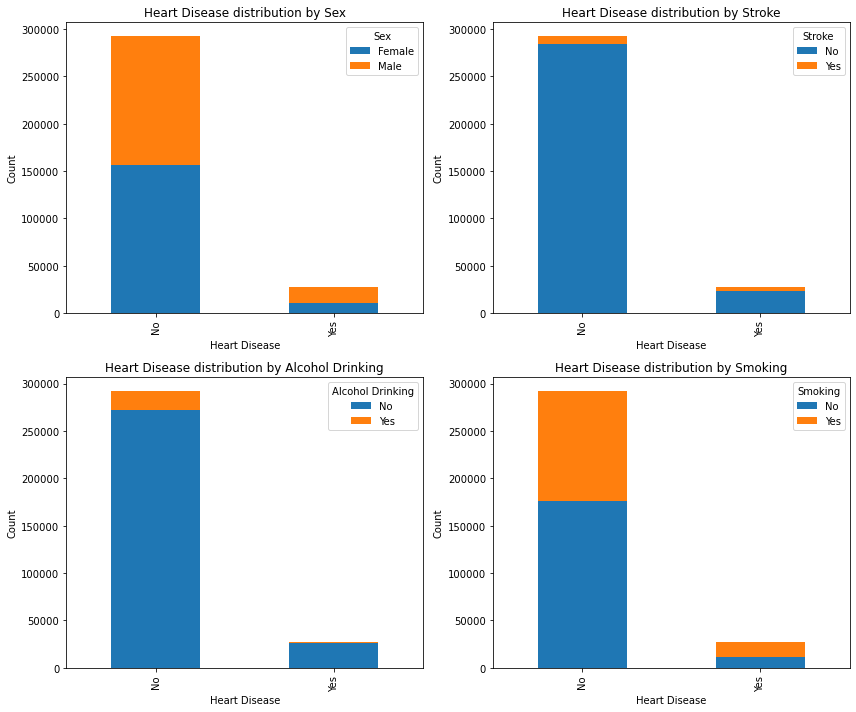

In [4]:
# Créer une figure avec 2 lignes et 2 colonnes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Graphique en fonction de "Sex"
df.groupby('Sex')['HeartDisease'].value_counts().unstack(0).plot(kind='bar', stacked=True, ax=axs[0, 0])
axs[0, 0].set_title('Heart Disease distribution by Sex')
axs[0, 0].set_xlabel('Heart Disease')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend(title='Sex', loc='upper right')

# Graphique en fonction de "Stroke"
df.groupby('Stroke')['HeartDisease'].value_counts().unstack(0).plot(kind='bar', stacked=True, ax=axs[0, 1])
axs[0, 1].set_title('Heart Disease distribution by Stroke')
axs[0, 1].set_xlabel('Heart Disease')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend(title='Stroke', loc='upper right')

# Graphique en fonction de "AlcoholDrinking"
df.groupby('AlcoholDrinking')['HeartDisease'].value_counts().unstack(0).plot(kind='bar', stacked=True, ax=axs[1, 0])
axs[1, 0].set_title('Heart Disease distribution by Alcohol Drinking')
axs[1, 0].set_xlabel('Heart Disease')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend(title='Alcohol Drinking', loc='upper right')

# Graphique en fonction de "Smoking"
df.groupby('Smoking')['HeartDisease'].value_counts().unstack(0).plot(kind='bar', stacked=True, ax=axs[1, 1])
axs[1, 1].set_title('Heart Disease distribution by Smoking')
axs[1, 1].set_xlabel('Heart Disease')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend(title='Smoking', loc='upper right')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

* Les hommes ont l'air d'être plus sujets aux maladies cardiaques
* La proportion de personnes ayant fait un AVC est plus élevée chez les gens ayant subi une maladie cardiaque
* En ce qui concerne l'alcool, la proportion est plus élevée chez les gens n'ayant pas fait de maladie cardiaque (paradoxal ?)
* La proportion de gens qui fument est plus élevé chez les gens qui fument

### II - Pré-traitement des données

#### II.1 - Valeurs manquantes

In [6]:
missing_values = df.isnull().sum()

# Affichez les résultats
print("Nombre de valeurs manquantes par colonne :")
print(missing_values)

Nombre de valeurs manquantes par colonne :
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


Le dataset a déjà été nettoyé et par conséquent ne contient pas valeurs manquantes

#### II.2 - Types des variables

In [7]:
types = df.dtypes
print(types)

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object


On constate qu'un certain nombre de variables (en particulier les variables qui peuvent prendre les valeurs 0 ou 1) ne sont pas au bon format

In [8]:
# Afficher les valeurs de la variable "HeartDisease" pour les observations 1, 501, 2700, 11 et 21000
observations_indices = [1, 501, 2700, 11, 21000]

for index in observations_indices:
    value_heart_disease = df.iloc[index]['HeartDisease']
    print(f'Observation {index}, HeartDisease: {value_heart_disease}')

Observation 1, HeartDisease: No
Observation 501, HeartDisease: No
Observation 2700, HeartDisease: No
Observation 11, HeartDisease: No
Observation 21000, HeartDisease: No


On utilise cette fonction pour pouvoir s'assurer que les 0 ont bien remplacés "No" et les 1 "Yes"

In [3]:
# Création d'un objet LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le LabelEncoder à la colonne HeartDisease
df['HeartDisease'] = label_encoder.fit_transform(df['HeartDisease'])

# Afficher le résultat
print(df['HeartDisease'])

0         0
1         0
2         0
3         0
4         0
         ..
319790    1
319791    0
319792    0
319793    0
319794    0
Name: HeartDisease, Length: 319795, dtype: int32


On utilise le label encoder pour transformer les 0 en "No" et les 1 en "Yes"

In [10]:
# Afficher les valeurs de la variable "HeartDisease" pour les observations 1, 501, 2700, 11 et 21000
observations_indices = [1, 501, 2700, 11, 21000]

for index in observations_indices:
    value_heart_disease = df.iloc[index]['HeartDisease']
    print(f'Observation {index}, HeartDisease: {value_heart_disease}')

Observation 1, HeartDisease: 0
Observation 501, HeartDisease: 0
Observation 2700, HeartDisease: 0
Observation 11, HeartDisease: 0
Observation 21000, HeartDisease: 0


On constate que les 0 correspondent bien à "No"

In [4]:
df['Smoking'] = label_encoder.fit_transform(df['Smoking'])
df['AlcoholDrinking'] = label_encoder.fit_transform(df['AlcoholDrinking'])
df['Stroke'] = label_encoder.fit_transform(df['Stroke'])
df['DiffWalking'] = label_encoder.fit_transform(df['DiffWalking'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['PhysicalActivity'] = label_encoder.fit_transform(df['PhysicalActivity'])
df['Asthma'] = label_encoder.fit_transform(df['Asthma'])
df['KidneyDisease'] = label_encoder.fit_transform(df['KidneyDisease'])
df['SkinCancer'] = label_encoder.fit_transform(df['SkinCancer'])

On fait pareil pour toutes les variables binaires

Maintenant il faut s'occuper des variables pouvant prendre plusieurs modalités, pour ce faire, nous allons utiliser OneHotEncoder

In [12]:
# Afficher les différentes modalités de la variable 'GenHealth'
print("Modalités de GenHealth :", df['GenHealth'].unique())

# Afficher les différentes modalités de la variable 'AgeCategory'
print("Modalités de AgeCategory :", df['AgeCategory'].unique())

# Afficher les différentes modalités de la variable 'Race'
print("Modalités de Race :", df['Race'].unique())

# Afficher les différentes modalités de la variable 'Diabetic'
print("Modalités de Diabetic :", df['Diabetic'].unique())

Modalités de GenHealth : ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
Modalités de AgeCategory : ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Modalités de Race : ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Modalités de Diabetic : ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']


On pourrait se dire qu'on pourrait regrouper certaines modalités notamment pour le diabète, mais nous faisons le choix de ne pas le faire puisqu'être diabétique parce qu'on est enceinte est relativement différent d'être diabétique sans cette composante.

**Variable GenHealth**

D'abord, on affiche les modalités pour voir lesquelles elles peuvent prendre

In [13]:
df.GenHealth.value_counts()

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

Ensuite, on applique le OneHotEncoder

In [5]:
#Sk one hot encoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['GenHealth']])

In [7]:
one_hot_names = ['Excellent','Fair','Good', 'Poor', 'VeryGood']
ohe_df = pd.DataFrame(transformed.toarray(), columns=one_hot_names)

On renomme dans cette ordre là puisque la fonction fait par ordre alphabétique

In [8]:
#On joint l'encoding puis on supprime le feature de base
df_to_train = df.join(ohe_df).drop('GenHealth',axis=1).dropna(axis=0)

On enlève la variable de base pour qu'elle en soit pas redondante

In [9]:
# Compte des occurrences de la catégorie 'VeryGood'
print(df_to_train['VeryGood'].value_counts())

# Compte des occurrences de la catégorie 'Good'
print(df_to_train['Good'].value_counts())

# Compte des occurrences de la catégorie 'Excellent'
print(df_to_train['Excellent'].value_counts())

# Compte des occurrences de la catégorie 'Fair'
print(df_to_train['Fair'].value_counts())

# Compte des occurrences de la catégorie 'Poor'
print(df_to_train['Poor'].value_counts())

0.0    205937
1.0    113858
Name: VeryGood, dtype: int64
0.0    226666
1.0     93129
Name: Good, dtype: int64
0.0    252953
1.0     66842
Name: Excellent, dtype: int64
0.0    285118
1.0     34677
Name: Fair, dtype: int64
0.0    308506
1.0     11289
Name: Poor, dtype: int64


Ca correspond bien à ce que nous avions, nous pouvons donc continuer avec les autres variables

**Variable AgeCategory**

On fait pareil pour la variable AgeCategory

In [18]:
df.AgeCategory.value_counts()

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

In [10]:
#Sk one hot encoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df_to_train[['AgeCategory']])

In [11]:
one_hot_names = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59','60-64','65-69','70-74','75-79','80+']
ohe_df = pd.DataFrame(transformed.toarray(), columns=one_hot_names)

On renomme dans l'ordre croissant

In [12]:
#On joint l'encoding puis on supprime le feature de base
df_to_train = df_to_train.join(ohe_df).drop('AgeCategory',axis=1).dropna(axis=0)

In [22]:
# Compte des occurrences de la catégorie '65-69'
print(df_to_train['65-69'].value_counts())

# Compte des occurrences de la catégorie '30-34'
print(df_to_train['30-34'].value_counts())

# Compte des occurrences de la catégorie '30-34'
print(df_to_train['80+'].value_counts())

0.0    285644
1.0     34151
Name: 65-69, dtype: int64
0.0    301042
1.0     18753
Name: 30-34, dtype: int64
0.0    295642
1.0     24153
Name: 80+, dtype: int64


Les catégorie correspondent bien

**Variable Race**

On fait pareil pour la variable Race

In [23]:
df.Race.value_counts()

White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: Race, dtype: int64

In [13]:
#Sk one hot encoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df_to_train[['Race']])

In [14]:
one_hot_names = ['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other', 'White']
ohe_df = pd.DataFrame(transformed.toarray(), columns=one_hot_names)

In [15]:
#On joint l'encoding puis on supprime le feature de base
df_to_train = df_to_train.join(ohe_df).drop('Race',axis=1).dropna(axis=0)

In [27]:
# Compte des occurrences de la catégorie 'American Indian'
print(df_to_train['American Indian/Alaskan Native'].value_counts())

# Compte des occurrences de la catégorie 'Asian'
print(df_to_train['Asian'].value_counts())

# Compte des occurrences de la catégorie 'White'
print(df_to_train['White'].value_counts())

0.0    314593
1.0      5202
Name: American Indian/Alaskan Native, dtype: int64
0.0    311727
1.0      8068
Name: Asian, dtype: int64
1.0    245212
0.0     74583
Name: White, dtype: int64


Les catégories correspodent bien

**Variable Diabetic**

On fait pareil pour la variable Diabetic

In [28]:
df.Diabetic.value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

In [16]:
#Sk one hot encoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df_to_train[['Diabetic']])

In [17]:
one_hot_names = ['No_diabetic', 'No_borderline_diabetic', 'Yes_diabetic', 'Yes_pregnancy_diabetic']
ohe_df = pd.DataFrame(transformed.toarray(), columns=one_hot_names)

In [18]:
#On joint l'encoding puis on supprime le feature de base
df_to_train = df_to_train.join(ohe_df).drop('Diabetic',axis=1).dropna(axis=0)

In [32]:
# Compte des occurrences de la catégorie 'No'
print(df_to_train['No_diabetic'].value_counts())

# Compte des occurrences de la catégorie 'No_borderline'
print(df_to_train['No_borderline_diabetic'].value_counts())

# Compte des occurrences de la catégorie 'Yes'
print(df_to_train['Yes_diabetic'].value_counts())

# Compte des occurrences de la catégorie 'Yes_pregnancy'
print(df_to_train['Yes_pregnancy_diabetic'].value_counts())

1.0    269653
0.0     50142
Name: No_diabetic, dtype: int64
0.0    313014
1.0      6781
Name: No_borderline_diabetic, dtype: int64
0.0    278993
1.0     40802
Name: Yes_diabetic, dtype: int64
0.0    317236
1.0      2559
Name: Yes_pregnancy_diabetic, dtype: int64


In [33]:
types = df_to_train.dtypes
print(types)

HeartDisease                        int32
BMI                               float64
Smoking                             int32
AlcoholDrinking                     int32
Stroke                              int32
PhysicalHealth                    float64
MentalHealth                      float64
DiffWalking                         int32
Sex                                 int32
PhysicalActivity                    int32
SleepTime                         float64
Asthma                              int32
KidneyDisease                       int32
SkinCancer                          int32
Excellent                         float64
Fair                              float64
Good                              float64
Poor                              float64
VeryGood                          float64
18-24                             float64
25-29                             float64
30-34                             float64
35-39                             float64
40-44                             

On met les variables nouvellement créées en format int32

In [19]:
# Liste des colonnes à convertir
columns_to_convert = ['Excellent', 'Fair', 'Good', 'Poor', 'VeryGood', '18-24', '25-29', '30-34', '35-39', '40-44',
                       '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+', 'American Indian/Alaskan Native',
                       'Asian', 'Black', 'Hispanic', 'Other', 'White', 'No_diabetic', 'No_borderline_diabetic', 'Yes_diabetic', 'Yes_pregnancy_diabetic']

# Conversion des colonnes de float64 à int32
df_to_train[columns_to_convert] = df_to_train[columns_to_convert].astype('int32')

# Affichage du nouveau type des colonnes
print(df_to_train.dtypes)

HeartDisease                        int32
BMI                               float64
Smoking                             int32
AlcoholDrinking                     int32
Stroke                              int32
PhysicalHealth                    float64
MentalHealth                      float64
DiffWalking                         int32
Sex                                 int32
PhysicalActivity                    int32
SleepTime                         float64
Asthma                              int32
KidneyDisease                       int32
SkinCancer                          int32
Excellent                           int32
Fair                                int32
Good                                int32
Poor                                int32
VeryGood                            int32
18-24                               int32
25-29                               int32
30-34                               int32
35-39                               int32
40-44                             

Déjà on aperçoit qu'on a un nombre élevé de variables, par conséquent il faudra surement par la suite réaliser une feature selection

In [35]:
df_to_train.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White,No_diabetic,No_borderline_diabetic,Yes_diabetic,Yes_pregnancy_diabetic
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,...,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,0.775362,...,0.016267,0.025229,0.071730,0.085824,0.034172,0.766779,0.843206,0.021204,0.127588,0.008002
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,0.417344,...,0.126499,0.156819,0.258041,0.280104,0.181671,0.422883,0.363607,0.144065,0.333631,0.089095
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### II.3 - Outliers

On créer deux sous-bases qui seront utiles par la suite : 
* Une qui contient uniquement des variables quantitatives
* Une qui contient uniquement des variables qualitatives

In [20]:
quantis = df_to_train.select_dtypes(include=['float64'])
qualis = df_to_train.select_dtypes(include=['int32'])

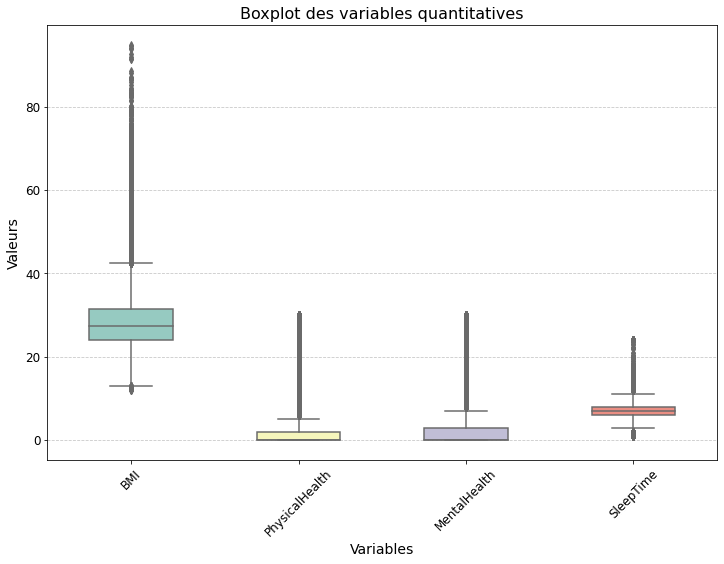

In [19]:
plt.figure(figsize=(12, 8))

# Utilisation de la palette de couleurs de seaborn
sns.set_palette("Set3")

# Utilisation de la fonction boxplot de seaborn
sns.boxplot(data=quantis, orient='v', width=0.5, fliersize=5)

# Rotation des labels sur l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, fontsize=12)

plt.title("Boxplot des variables quantitatives", fontsize=16)
plt.ylabel("Valeurs", fontsize=14)
plt.xlabel("Variables", fontsize=14)

# Ajout d'une grille pour une meilleure lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Personnalisation des axes
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

On constate qu'il existe un grand nombre de valeurs potentiellement atypiques pour toutes nos variables quantitatives

In [20]:
# Calculer les limites des boîtes à moustaches (whiskers)
def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (lower_bound, upper_bound)

# Identifier les observations atypiques
outliers = {}
for column in quantis.columns:
    lower_bound, upper_bound = find_outliers(quantis[column])
    outliers[column] = quantis[(quantis[column] < lower_bound) | (quantis[column] > upper_bound)]

# Afficher les observations atypiques
for column, outlier_data in outliers.items():
    print(f"Variable : {column}")
    print(outlier_data)
    print("\n")

Variable : BMI
          BMI  PhysicalHealth  MentalHealth  SleepTime
32      45.35            30.0           0.0        8.0
57      46.52            30.0           0.0        8.0
90      44.29            30.0          10.0        7.0
105     58.54            30.0           0.0        3.0
107     45.42             0.0           0.0        7.0
...       ...             ...           ...        ...
319693  44.29             0.0           0.0        7.0
319709  51.46            30.0           0.0        7.0
319725  53.16            29.0           0.0        5.0
319777  42.57             0.0           0.0        7.0
319794  46.56             0.0           0.0        8.0

[10396 rows x 4 columns]


Variable : PhysicalHealth
          BMI  PhysicalHealth  MentalHealth  SleepTime
2       26.58            20.0          30.0        8.0
4       23.71            28.0           0.0        8.0
5       28.87             6.0           0.0       12.0
6       21.63            15.0           0.0        

* 10396 valeurs atypiques pour la variables BMI
* 47146 valeurs atypiques pour la variable PhysicalHealth
* 51576 valeurs atypiques pour la variable MentalHealth
* 4543 valeurs atypiques pour la variables SleepTime

C'est la variable MentalHealth qui possède le plus de valeurs atypiques

In [39]:
# Obtenez les indices des observations atypiques
outliers = []
for line in quantis.columns:
    y = quantis[line]
    q1 = y.quantile(0.25)
    q3 = y.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers.extend(y[(y < lower_bound) | (y > upper_bound)].index)

# Supprimez les doublons des indices d'observations atypiques
outliers = list(set(outliers))

# Affichez les indices des observations atypiques
print("Indices des observations atypiques:", outliers)

Indices des observations atypiques: [262144, 0, 2, 262146, 4, 5, 6, 262149, 262151, 10, 262155, 13, 14, 17, 262162, 262163, 22, 23, 25, 26, 262172, 32, 35, 262184, 40, 262186, 43, 44, 49, 262194, 262193, 262196, 262197, 54, 55, 50, 57, 262203, 262208, 65, 66, 262209, 262212, 262214, 71, 76, 262221, 78, 262223, 80, 81, 262225, 262227, 84, 262230, 262232, 90, 262240, 97, 262242, 262243, 100, 101, 96, 99, 262247, 105, 106, 107, 262251, 262250, 262253, 111, 262256, 262254, 115, 119, 121, 262268, 262270, 126, 262272, 262273, 130, 128, 262276, 136, 138, 139, 262284, 142, 262286, 262288, 144, 262287, 262289, 262290, 262291, 152, 155, 156, 157, 160, 262305, 162, 262309, 166, 262310, 262312, 262313, 170, 171, 165, 262317, 175, 176, 262319, 262324, 262326, 262327, 184, 262329, 262330, 188, 262335, 192, 262336, 195, 262339, 262343, 200, 262348, 206, 207, 262352, 209, 262354, 213, 262359, 216, 217, 218, 219, 262363, 222, 262366, 228, 229, 262372, 262374, 231, 233, 262376, 235, 262378, 239, 240, 26

Le but de cette manipulation était d'essayer de voir si des observations atypiques étaient présente plusieurs fois, mais on ne peut pas voir grâce à ce code donc on a fait celui en dessous

In [40]:
# Compter les occurrences de chaque observation atypique
outlier_counts = pd.Series(outliers).value_counts()

# Afficher les observations atypiques avec leurs fréquences
print("Observations atypiques et leurs fréquences:")
print(outlier_counts)

# Vous pouvez également afficher le top N des observations les plus fréquentes
# Par exemple, les 5 observations les plus fréquentes
top_n_outliers = outlier_counts.head(100)
print("\nTop 5 observations atypiques les plus fréquentes:")
print(top_n_outliers)

Observations atypiques et leurs fréquences:
262144    1
154431    1
154479    1
154475    1
154468    1
         ..
51704     1
313847    1
51702     1
51701     1
262143    1
Length: 88775, dtype: int64

Top 5 observations atypiques les plus fréquentes:
262144    1
154431    1
154479    1
154475    1
154468    1
         ..
154770    1
154763    1
154758    1
154794    1
154750    1
Length: 100, dtype: int64


Il n'y pas de valeurs atypiques qui reviennent plusieurs fois

**z-score = 3**

In [21]:
columns_to_process = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]

# Copier le DataFrame original pour éviter de modifier les données d'origine
df_without_outliers = df_to_train.copy()

# Boucle sur les colonnes spécifiées
for column in columns_to_process:
    # Calcul des Z-scores pour chaque point de données
    z_scores = stats.zscore(df_without_outliers[column])
    
    # Définir un seuil pour considérer un point comme une valeur atypique (par exemple, Z-score > 3)
    threshold = 3
    
    # Filtrer les valeurs atypiques en fonction des Z-scores
    df_without_outliers = df_without_outliers[(z_scores <= threshold) & (z_scores >= -threshold)]

# Afficher le DataFrame sans les valeurs atypiques
print(df_without_outliers)

        HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
1                  0  20.34        0                0       1             0.0   
3                  0  24.21        0                0       0             0.0   
6                  0  21.63        0                0       0            15.0   
7                  0  31.64        1                0       0             5.0   
8                  0  26.45        0                0       0             0.0   
...              ...    ...      ...              ...     ...             ...   
319789             0  22.22        0                0       0             0.0   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319794             0  46.56        0                0       0             0.0   

        MentalHealth  DiffW

Il reste 278941 observations

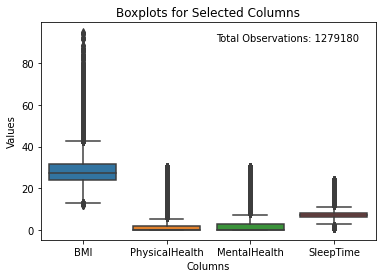

In [22]:
df_without_outliers = quantis.copy()

sns.boxplot(data=df_without_outliers[columns_to_process])

# Add titles and labels
plt.title("Boxplots for Selected Columns")
plt.xlabel("Columns")
plt.ylabel("Values")

# Calculate the total number of observations
total_observations = sum(len(df_without_outliers[column]) for column in columns_to_process)

# Add text annotation for total observations in the top right corner
plt.text(0.95, 0.95, f'Total Observations: {total_observations}', 
         ha='right', va='top', transform=plt.gca().transAxes)

# Show the plot
plt.show()

Avec le z-score = 3, il y a de nombreuses valeurs atypiques encore

**z-score = 1**

In [23]:
columns_to_process = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]

# Copier le DataFrame original pour éviter de modifier les données d'origine
df_without_outliers1 = df_to_train.copy()

# Boucle sur les colonnes spécifiées
for column in columns_to_process:
    # Calcul des Z-scores pour chaque point de données
    z_scores = stats.zscore(df_without_outliers[column])
    
    # Définir un seuil pour considérer un point comme une valeur atypique 
    threshold = 1
    
    # Filtrer les valeurs atypiques en fonction des Z-scores
    df_without_outliers1 = df_without_outliers1[(z_scores <= threshold) & (z_scores >= -threshold)]

# Afficher le DataFrame sans les valeurs atypiques
print(df_without_outliers1)

        HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
3                  0  24.21        0                0       0             0.0   
12                 0  28.37        1                0       0             0.0   
13                 0  28.15        0                0       0             7.0   
15                 0  29.18        0                0       0             1.0   
21                 0  28.90        0                0       0             2.0   
...              ...    ...      ...              ...     ...             ...   
319786             1  33.20        1                0       0             0.0   
319788             0  23.38        0                0       0             0.0   
319789             0  22.22        0                0       0             0.0   
319790             1  27.41        1                0       0             7.0   
319792             0  24.24        0                0       0             0.0   

        MentalHealth  DiffW

C:\Users\Chataigner\AppData\Local\Temp\ipykernel_30028\3776043178.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outliers1 = df_without_outliers1[(z_scores <= threshold) & (z_scores >= -threshold)]


Il reste 166607 observations

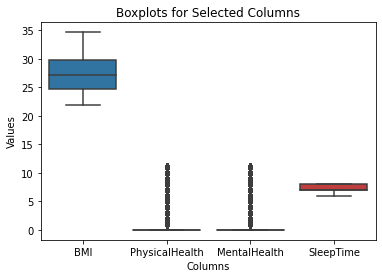

In [24]:
sns.boxplot(data=df_without_outliers1[columns_to_process])

# Add titles and labels
plt.title("Boxplots for Selected Columns")
plt.xlabel("Columns")
plt.ylabel("Values")

# Calculate the total number of observations
total_observations = sum(len(df_without_outliers1[column]) for column in columns_to_process)
# Show the plot
plt.show()

Avec le z-score = 1 il n'y a plus de valeurs atypiques pour BMI et SleepTime, en revanche il en reste PhysicalHealth et MentalHealth

**z-score = 0.5**

In [23]:
columns_to_process = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]

# Copier le DataFrame original pour éviter de modifier les données d'origine
df_without_outliers2 = df_to_train.copy()

# Boucle sur les colonnes spécifiées
for column in columns_to_process:
    # Calcul des Z-scores pour chaque point de données
    z_scores = stats.zscore(df_without_outliers2[column])
    
    # Définir un seuil pour considérer un point comme une valeur atypique (par exemple, Z-score > 3)
    threshold = 0.5
    
    # Filtrer les valeurs atypiques en fonction des Z-scores
    df_without_outliers2 = df_without_outliers2[(z_scores <= threshold) & (z_scores >= -threshold)]

# Afficher le DataFrame sans les valeurs atypiques
print(df_without_outliers2)

        HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
21                 0  28.90        0                0       0             2.0   
51                 0  31.09        0                0       0             2.0   
52                 0  27.12        1                0       0             2.0   
58                 0  29.55        0                0       0             0.0   
117                0  26.22        0                0       0             0.0   
...              ...    ...      ...              ...     ...             ...   
319749             0  26.57        0                0       0             0.0   
319758             1  28.32        1                0       0             0.0   
319762             0  30.41        0                0       0             0.0   
319769             0  25.25        0                0       0             0.0   
319772             0  30.90        0                0       0             0.0   

        MentalHealth  DiffW

Il reste 33163 observations

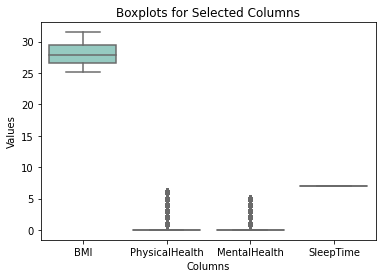

In [46]:
sns.boxplot(data=df_without_outliers2[columns_to_process])

# Add titles and labels
plt.title("Boxplots for Selected Columns")
plt.xlabel("Columns")
plt.ylabel("Values")

# Calculate the total number of observations
total_observations = sum(len(df_without_outliers2[column]) for column in columns_to_process)

# Show the plot
plt.show()

Avec le z-score = 0.5 il n'y a plus de valeurs atypiques pour BMI et SleepTime, en revanche il en reste PhysicalHealth et MentalHealth

#### II.4 - Relations entre les variables

##### II.4.1 - Corrélations

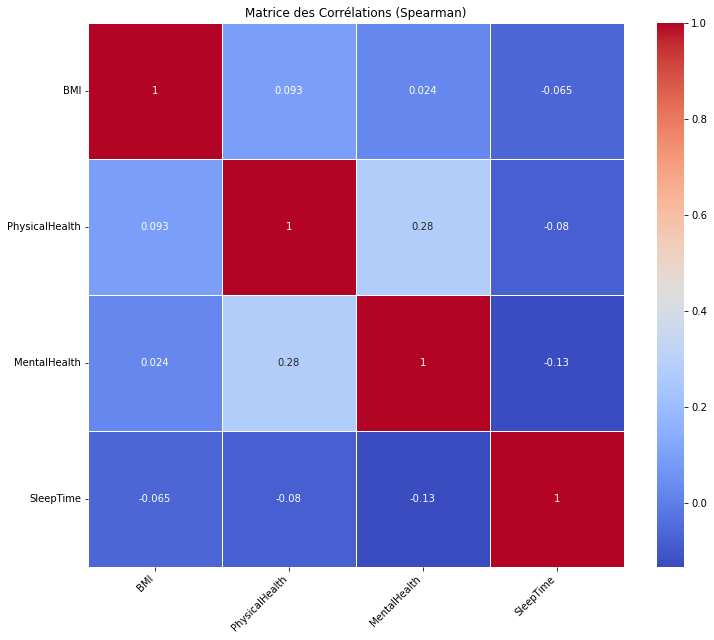

In [47]:
# Calculer la matrice des corrélations de Spearman
correlation_matrix_spearman, _ = spearmanr(quantis)

# Créer une heatmap avec Seaborn pour la matrice des corrélations de Spearman
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', linewidths=.5)

# Extraire les noms des colonnes
column_names = quantis.columns

# Ajouter les noms des variables sur les axes
heatmap.set_xticklabels(column_names, rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(column_names, rotation=0, horizontalalignment='right')

plt.title('Matrice des Corrélations (Spearman)')
plt.show()

* On utilise spearman car pearson suppose que les données suivent une loi normale contrairement à Spearman
* Pas de corrélation significative, on peut laisser les variables quantitatives puisqu'il n'y en a que 4 et qu'elles ne sont pas corrélées

##### II.4.2 - Liens entre les variables qualitatives

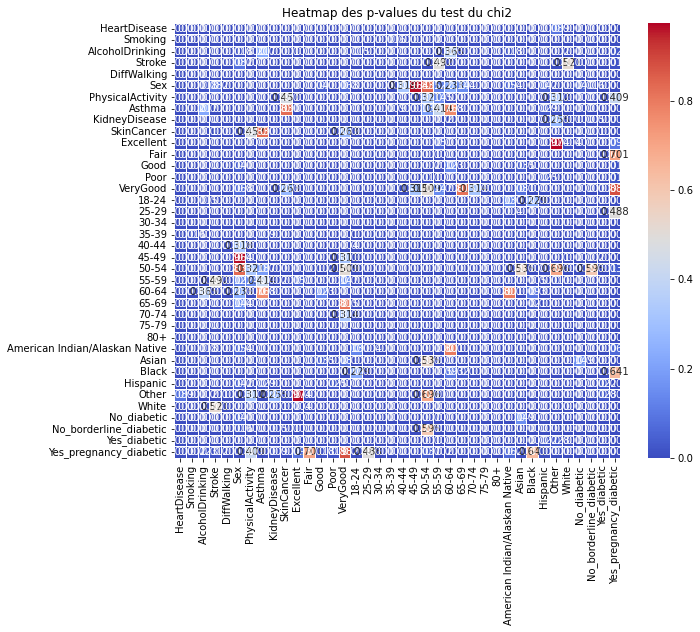

In [48]:
# Calcul des p-values du chi2 pour chaque paire de variables
p_values = pd.DataFrame(index=qualis.columns, columns=qualis.columns)

for col1 in qualis.columns:
    for col2 in qualis.columns:
        contingency_table = pd.crosstab(qualis[col1], qualis[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values.at[col1, col2] = p_value

# Convertir les p-values en valeurs numériques
p_values = p_values.apply(pd.to_numeric)

# Création de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values, annot=True, cmap="coolwarm", fmt=".3f", linewidths=.5)
plt.title("Heatmap des p-values du test du chi2")
plt.show()

Grâce au graphique on constate qu'il y a un grand nombre de couples de variables ayant un lien, on regarde les p-values pour que ça soit plus lisible

In [49]:
# Calcul des p-values du chi2 pour chaque paire de variables
p_values = pd.DataFrame(index=qualis.columns, columns=qualis.columns)

for col1 in qualis.columns:
    for col2 in qualis.columns:
        contingency_table = pd.crosstab(qualis[col1], qualis[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values.at[col1, col2] = p_value

# Convertir les p-values en valeurs numériques
p_values = p_values.apply(pd.to_numeric)

# Définir le seuil de signification (alpha)
alpha = 0.05

# Vérifier chaque p-value et imprimer un message
for col1 in p_values.columns:
    for col2 in p_values.index:
        p_value = p_values.at[col1, col2]
        if p_value > alpha:
            print(f"Il n'y a pas de lien significatif entre {col1} et {col2}. P-value = {p_value:.3f}")
        else:
            print(f"Il y a un lien significatif entre {col1} et {col2}. P-value = {p_value:.3f}")

Il y a un lien significatif entre HeartDisease et HeartDisease. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Smoking. P-value = 0.000
Il y a un lien significatif entre HeartDisease et AlcoholDrinking. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Stroke. P-value = 0.000
Il y a un lien significatif entre HeartDisease et DiffWalking. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Sex. P-value = 0.000
Il y a un lien significatif entre HeartDisease et PhysicalActivity. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Asthma. P-value = 0.000
Il y a un lien significatif entre HeartDisease et KidneyDisease. P-value = 0.000
Il y a un lien significatif entre HeartDisease et SkinCancer. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Excellent. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Fair. P-value = 0.000
Il y a un lien significatif entre HeartDisease et Good. P-value = 0.000


Au seuil de 5%, il existe de nombreux couples de variables qualitatives qui ont des liens entre elles. En particulier avec la variable target.

##### II.4.3 - Liens entre les variables quantitatives & qualitatives

In [50]:
# Affichez les moyennes pour chaque groupe
print(df_to_train.groupby('HeartDisease')['BMI'].mean())
print(df_to_train.groupby('HeartDisease')['MentalHealth'].mean())
print(df_to_train.groupby('HeartDisease')['PhysicalHealth'].mean())
print(df_to_train.groupby('HeartDisease')['SleepTime'].mean())

# Effectuez le test t de Student pour chaque variable
def perform_t_test(grouped_df, variable_name):
    group1 = grouped_df.get_group(0)  # Remplacez 0 par la catégorie de référence
    group2 = grouped_df.get_group(1)  # Remplacez 1 par l'autre catégorie
    t_statistic, p_value = ttest_ind(group1[variable_name], group2[variable_name], equal_var=False)
    print(f"\nTest t-statistic ({variable_name}):", t_statistic)
    print(f"P-value ({variable_name}):", p_value)

# Effectuez le test t de Student pour chaque variable
grouped_df = df_to_train.groupby('HeartDisease')
perform_t_test(grouped_df, 'BMI')
perform_t_test(grouped_df, 'MentalHealth')
perform_t_test(grouped_df, 'PhysicalHealth')
perform_t_test(grouped_df, 'SleepTime')

HeartDisease
0    28.224658
1    29.401592
Name: BMI, dtype: float64
HeartDisease
0    3.828778
1    4.641764
Name: MentalHealth, dtype: float64
HeartDisease
0    2.956416
1    7.808242
Name: PhysicalHealth, dtype: float64
HeartDisease
0    7.093416
1    7.136156
Name: SleepTime, dtype: float64

Test t-statistic (BMI): -28.401634262333364
P-value (BMI): 2.7721495948880634e-175

Test t-statistic (MentalHealth): -14.18925411954749
P-value (MentalHealth): 1.4801017749729575e-45

Test t-statistic (PhysicalHealth): -68.55723076591224
P-value (PhysicalHealth): 0.0

Test t-statistic (SleepTime): -3.8606587009234725
P-value (SleepTime): 0.00011331398017915307


Conclusions : 
* Il y a une différence significative d'IMC entre le groupe des personnes n'ayant pas de maladie cardiaque (HeartDisease = 0) et le groupe des personnes ayant une maladie cardiaque (HeartDisease = 1)
* Il y a une différence significative dans la santé mentale entre les deux groupes
* Il y a une différence significative dans la santé physique entre les deux groupes
* Il y a une différence significative dans le temps de sommeil entre les deux groupes

#### II.5 - Feature Selection

In [23]:
# Séparer les caractéristiques (X) de la variable cible (y)
X = qualis.drop("HeartDisease", axis=1)
y = qualis["HeartDisease"]

# Appliquer le test du Chi2 pour sélectionner les caractéristiques les plus importantes
# Toutes les caractéristiques seront conservées par défaut, SelectKBest pour séléctionner K optimal
#k = 6  # Pour changer k
#chi2_selector = SelectKBest(chi2, k=k)
chi2_selector = SelectKBest(chi2)
X_kbest = chi2_selector.fit_transform(X, y)

# Afficher les noms des caractéristiques sélectionnées
selected_features = X.columns[chi2_selector.get_support()]
print("Caractéristiques sélectionnées:", selected_features.tolist())

Caractéristiques sélectionnées: ['Stroke', 'DiffWalking', 'KidneyDisease', 'SkinCancer', 'Excellent', 'Fair', 'Poor', '75-79', '80+', 'Yes_diabetic']


Nous réalisons un Chi2 Feature Selection. On utilise le Chi2 comme méthode de sélection en fonction d'un test statistique. `SelectKBest` sélectionne les meilleures caractéristiques en fonction d'une mesure spécifique fournie en tant que paramètre. 

On obtient le dataframe suivant : 

In [24]:
# Liste des variables à conserver
selected_variables = ['HeartDisease', 'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
                       'Stroke', 'DiffWalking', 'KidneyDisease', 'SkinCancer', 
                       'Excellent', 'Fair', 'Poor', '75-79', '80+', 'Yes_diabetic']

# Sélectionner les colonnes spécifiées dans un nouveau DataFrame
df_model = df_without_outliers1[selected_variables].copy()

In [25]:
df_model.sample(5)

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Stroke,DiffWalking,KidneyDisease,SkinCancer,Excellent,Fair,Poor,75-79,80+,Yes_diabetic
280015,1,25.39,0.0,0.0,7.0,0,0,0,0,0,0,0,0,0,0
157215,0,27.40,0.0,0.0,6.0,0,0,0,0,0,0,0,0,0,0
131270,0,31.64,2.0,2.0,7.0,0,0,1,0,0,0,0,0,1,0
84645,0,31.20,0.0,0.0,7.0,0,0,0,0,0,0,0,0,0,0
180385,0,26.50,0.0,2.0,6.0,0,0,0,0,0,0,0,0,0,0


Nous avons alors 14 variables explicatives, il serait intéressant de diminuer la valeur de k par la suite.

Deuxième feature selection basée sur la variance

In [25]:
# Supprimer les caractéristiques avec une variance inférieure à un seuil
selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(qualis.drop("HeartDisease", axis=1), qualis["HeartDisease"])

# Récupérer les noms des caractéristiques sélectionnées
selected_feature_names = qualis.drop("HeartDisease", axis=1).columns[selector.get_support()]

# Afficher les noms des caractéristiques sélectionnées
print("Caractéristiques sélectionnées:", selected_feature_names.tolist())

Caractéristiques sélectionnées: ['Smoking', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'Excellent', 'Good', 'VeryGood', 'White', 'No_diabetic', 'Yes_diabetic']


In [26]:
# Liste des variables à conserver
selected_variables = ['HeartDisease', 'BMI', 'SleepTime', 'PhysicalHealth', 'MentalHealth',
                      'Smoking', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'Excellent', 'Good', 'VeryGood', 'White', 'No_diabetic', 'Yes_diabetic']

# Sélectionner les colonnes spécifiées dans un nouveau DataFrame
df_model_15 = df_without_outliers1[selected_variables].copy()

Certaines variables sont communes mais nous en obtenons pas mal de différentes donc ça peut être intéressant

### III - Préparation des données

#### III.1 - Split du jeu de données

In [25]:
#Train and test
X_train , X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:],
                                                     df_model.HeartDisease,
                                                     test_size=0.2)

In [27]:
#Target déséquilibrée
y_train.value_counts()

0    124204
1      9081
Name: HeartDisease, dtype: int64

Comme nous l'avions constaté, la target est déséquilibré : nous procédons à un sous-échantillonage sur les données d'entraînement

In [26]:
# Appliquer l'échantillonnage stratifié uniquement sur l'ensemble d'entraînement
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [29]:
#Target équilibrée
y_train_resampled.value_counts() 

0    9081
1    9081
Name: HeartDisease, dtype: int64

Désormais elle est équilibrée

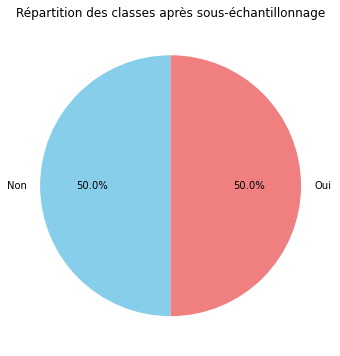

In [28]:
# Mapping des classes à des labels plus explicites
class_labels = {0: "Non", 1: "Oui"}

# Remplacement des labels dans y_train_resampled
y_train_resampled_labels = y_train_resampled.map(class_labels)

# Création du pie plot
plt.figure(figsize=(6, 6))
y_train_resampled_labels.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Répartition des classes après sous-échantillonnage')
plt.ylabel('')  # Supprime l'étiquette du côté y
plt.show()

Le rééchantillonnage est souvent appliqué dans des ensembles de données déséquilibrés pour équilibrer la représentation des classes. Il est généralement recommandé de rééchantillonner uniquement l'ensemble d'entraînement pour plusieurs raisons :

1. **Préservation de la réalité du problème :** Le modèle doit généraliser à de nouvelles données qui reflètent la distribution réelle du problème.

2. **Évaluation sur des données non modifiées :** En conservant l'ensemble de test inchangé, l'évaluation du modèle reste représentative des conditions réelles.

3. **Éviter la fuite d'informations :** Rééchantillonner l'ensemble de test peut conduire à une fuite d'informations, biaisant l'évaluation du modèle.

4. **Considérations pratiques :** Souvent, l'ensemble d'entraînement est beaucoup plus grand, justifiant le rééchantillonnage pour compenser le déséquilibre de classe.

#### III.2 - Standardisation

On standardise uniquement sur les variables quantitatives

In [27]:
# Sélection des variables à scaler
selected_features = ["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]

# Création d'un scaler
scaler = StandardScaler()

# Calcul de la moyenne et de l'écart type sur X_train_resampled pour les variables sélectionnées
scaler.fit(X_train_resampled[selected_features])

StandardScaler()

On rajoute les variables qualitatives au dataframe où les variables quantitatives ont été standardisées

In [28]:
# Transformation des variables sélectionnées dans X_train_resampled
X_train_resampled[selected_features] = scaler.transform(X_train_resampled[selected_features])

# Transformation des variables sélectionnées dans X_test
X_test[selected_features] = scaler.transform(X_test[selected_features])

# Renommer les DataFrames
X_train_resampled_sc = X_train_resampled.copy()
X_test_sc = X_test.copy()

| Bases                  | Description                              |
|------------------------|------------------------------------------|
| X_train_resampled_sc | X train ré-échantillonné 1ere analyse    | 
| X_test_sc            | X test 1ere analyse                       |
| y_train_resampled    | y train ré-échantillonné 1ere analyse    |
| y_test              | y test 1ere analyse                       |


In [247]:
X_train_resampled_sc.sample(5)

,BMI,SleepTime,Smoking,Sex,PhysicalActivity,Excellent,Good,VeryGood,White
238061,0.815257,-1.518730,1,1,1,0,1,0,0
281191,1.137604,1.066471,1,1,1,0,1,0,1
229369,-0.771915,-1.518730,1,1,1,0,0,1,1
241600,1.834486,1.066471,1,0,1,0,0,0,0
25883,0.056976,1.066471,1,0,0,0,0,1,0


In [130]:
X_test_sc.head(5)

,BMI,PhysicalHealth,MentalHealth,SleepTime,Stroke,DiffWalking,KidneyDisease,SkinCancer,Excellent,Fair,Poor,75-79,80+,Yes_diabetic
298128,-0.977618,-0.402281,1.000572,-0.231153,0,0,0,1,0,0,0,0,0,0
88271,-0.808252,0.565545,-0.406040,-0.231153,0,0,0,0,0,0,0,0,0,0
15928,-1.467240,4.436848,-0.406040,-1.523152,0,0,0,0,0,1,0,0,1,0
104214,-0.038406,-0.402281,-0.406040,-0.231153,0,0,0,1,0,0,0,0,0,1
206842,-0.768220,-0.402281,-0.406040,-0.231153,0,0,0,0,0,0,0,0,0,0


### IV - Modèles

#### IV.1 - Modèle ré-échantilloné avec 14 variables

##### IV.1.1 - Comparaisons

On réalise 10 différents modèles 

In [248]:
# Regression logistique
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_resampled_sc, y_train_resampled)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_resampled_sc, y_train_resampled)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_resampled_sc,y_train_resampled)

#SVM avec noyau RBF
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train_resampled_sc, y_train_resampled)

#SGD poly
svc_poly = SVC(kernel='poly',random_state=0)
svc_poly.fit(X_train_resampled_sc, y_train_resampled)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_resampled_sc, y_train_resampled)

#Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled_sc, y_train_resampled)

#Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled_sc, y_train_resampled)

#XGBoost
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_resampled_sc, y_train_resampled)

#K-Nearest Neighbors 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_resampled_sc, y_train_resampled)

KNeighborsClassifier()

##### IV.1.2 - Choix du modèle

On effectue une validation croisée à 5 folds pour mesurer la performance des différents modèles

In [249]:
# Get cross_val_score for each function

cvs_lgr = cross_val_score(lgr, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_lsvc = cross_val_score(l_SVC, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_svc = cross_val_score(svc, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_rbf = cross_val_score(rbf_svc, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_poly = cross_val_score(svc_poly, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_sgdc = cross_val_score(sgdc_svm, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_rf = cross_val_score(rf_classifier, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_gb = cross_val_score(gb_classifier, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_xgb = cross_val_score(xgb_classifier, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

cvs_knn = cross_val_score(knn_classifier, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

In [250]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_lgr,cvs_lsvc,cvs_svc,cvs_rbf,cvs_poly,cvs_sgdc,cvs_rf,cvs_gb,cvs_xgb,cvs_knn]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['lgr','lsvc','svc','rbf', 'poly', 'sgdc', 'rf', 'gb', 'xgb', 'knn']

In [251]:
df_cross

,fold1,fold2,fold3,fold4,fold5,model
0,0.680332,0.699640,0.677196,0.685231,0.681629,lgr
1,0.683380,0.700194,0.671931,0.683569,0.679135,lsvc
2,0.659003,0.678304,0.650319,0.664450,0.651704,svc
3,0.667867,0.697423,0.673040,0.683569,0.677473,rbf
4,0.670637,0.696592,0.673871,0.684677,0.677196,poly
5,0.659003,0.678304,0.650319,0.664450,0.651704,sgdc
6,0.601662,0.608202,0.596010,0.597395,0.601829,rf
7,0.674238,0.693821,0.674148,0.682738,0.677750,gb
8,0.664266,0.674425,0.656415,0.662787,0.675533,xgb
9,0.627978,0.641452,0.620116,0.624550,0.629260,knn


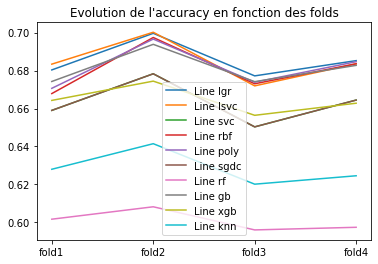

In [252]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [253]:
for i in range(10):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.6848057449481867 et un std : 0.008778390556330588
Le modèle N° 1 a une accuray de 0.6836418188139992 et un std : 0.010386181999531438
Le modèle N° 2 a une accuray de 0.660755943321137 et un std : 0.011352706230009082
Le modèle N° 3 a une accuray de 0.679874321582931 et un std : 0.011382705614966062
Le modèle N° 4 a une accuray de 0.6805945892424985 et un std : 0.010350008949478125
Le modèle N° 5 a une accuray de 0.660755943321137 et un std : 0.011352706230009082
Le modèle N° 6 a une accuray de 0.6010195809337844 et un std : 0.004766588581193413
Le modèle N° 7 a une accuray de 0.6805389726668248 et un std : 0.008209273270730195
Le modèle N° 8 a une accuray de 0.6666852720461082 et un std : 0.008135227610601856
Le modèle N° 9 a une accuray de 0.6286712120898125 et un std : 0.00797411559061412


Le meilleur modèle en terme d'accuracy est le lgr (même s'il n'a pas le std le plus faible, le modèle en a un assez faible)

##### IV.1.3 - Grid Search

In [254]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [255]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300]  
}

c_lgr = LogisticRegression(random_state=42)

In [256]:
grid_c_lgr_= GridSearchCV(c_lgr, param_grid=params, cv=5, return_train_score=True)

In [257]:
take_grid = grid_c_lgr_.fit(X_train_resampled_sc, y_train_resampled)

In [258]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
pour un score de: 0.6848057449481867


On constate que le `GridSearch` n'améliore pas le modèle, il reste pareil

##### IV.1.4 - Learning curve

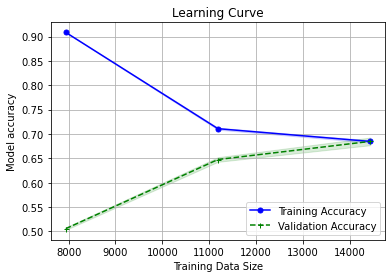

In [259]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_lgr, 
                                                        X=X_train_resampled_sc, 
                                                        y=y_train_resampled,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

* La courbe bleue représente la précision d'entraînement, diminuant avec l'augmentation de la taille des données, indiquant une possible réduction du surapprentissage.
* La courbe verte pointillée représente la précision de validation, augmentant avec la taille des données, montrant une amélioration de la généralisation du modèle.
* Au début, il y a un grand écart entre la précision d'entraînement et de validation, suggérant un surapprentissage, mais cet écart diminue à mesure que la taille des données augmente, indiquant une meilleure généralisation du modèle.

En résumé, l'ajout de données d'entraînement améliore la capacité du modèle à généraliser sur de nouvelles données, comme le montre l'augmentation de la précision de validation, et il y a une tendance vers une meilleure convergence entre la performance sur les données d'entraînement et de validation, ce qui est souhaitable dans la construction de modèles de machine learning.

##### IV.1.5 - Matrice de confusion

In [260]:
take_grid.best_params_

{'C': 1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [261]:
best_lgr = LogisticRegression(C=1, class_weight=None, max_iter=100, penalty='l1', solver='liblinear')

In [264]:
best_lgr.fit(X_train_resampled_sc, y_train_resampled)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [265]:
print('Training score: ' + str(best_lgr.score(X_train_resampled_sc, y_train_resampled)), 
      '\n',
      'Test score: ' + str(best_lgr.score(X_test_sc, y_test))
     )

Training score: 0.6846946691787654 
 Test score: 0.6856731288638137


Les scores sont équivalents, le modèle semble stable : pas de sur/sous ajustement 

In [29]:
# Créer le modèle de régression logistique avec les paramètres optimaux
modele_regression_logistique = LogisticRegression(C=1, class_weight=None, max_iter=100, penalty='l1', solver='liblinear')

# Entraîner le modèle avec vos données
modele_regression_logistique.fit(X_train_resampled_sc, y_train_resampled)

# Faire des prédictions avec le modèle entraîné
predictions = modele_regression_logistique.predict(X_test)


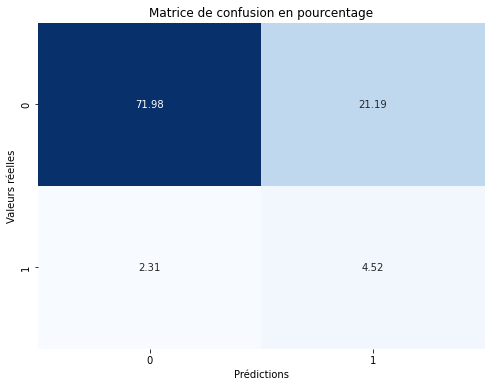

In [31]:
# Calculer la matrice de confusion en pourcentage
total = np.sum(matrice_confusion)
matrice_confusion_percent = (matrice_confusion / total) * 100

# Créer le graphique de la matrice de confusion en pourcentage
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_confusion_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.title("Matrice de confusion en pourcentage")
plt.show()

71.98% des échantillons sans maladie cardiaque ont été correctement prédits comme n'ayant pas de maladie cardiaque, et 4.52% des échantillons avec maladie cardiaque ont été correctement prédits comme en ayant une. Le modèle prédit mal les gens ayant réellement une maladie cardiaque

In [274]:
# Prédire les étiquettes sur l'ensemble de test et d'entraînement
y_pred_train = best_lgr.predict(X_train_resampled_sc)
y_pred_test = best_lgr.predict(X_test_sc)

# Calculer le score F1 pour l'ensemble d'entraînement et de test
f1_train = f1_score(y_train_resampled, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# Afficher les scores F1
print('F1 Score (Entraînement): {:.4f}'.format(f1_train))
print('F1 Score (Test): {:.4f}'.format(f1_test))

F1 Score (Entraînement): 0.6824
F1 Score (Test): 0.2269


F1 Score plutôt faible

##### IV.1.6 - Importance des variables

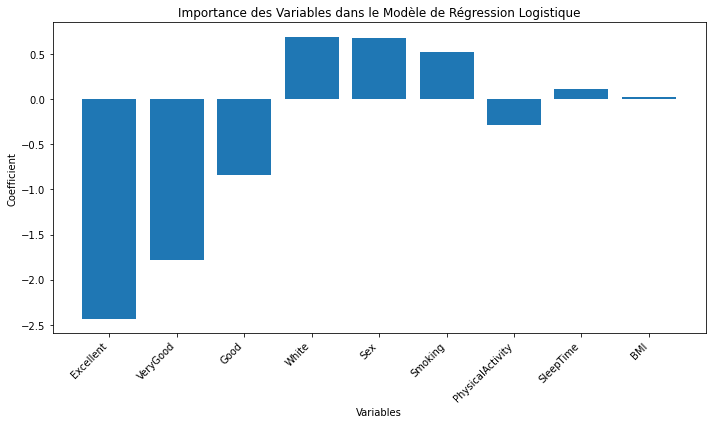

In [278]:
# Récupérer les coefficients du modèle
coefficients = best_lgr.coef_[0]

# Récupérer les noms des variables
feature_names = X_train_resampled_sc.columns

# Trier les indices par ordre décroissant des coefficients absolus
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[sorted_indices])
plt.xticks(range(len(coefficients)), np.array(feature_names)[sorted_indices], rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Importance des Variables dans le Modèle de Régression Logistique')
plt.tight_layout()
plt.show()


* Avoir un santé excellente, très bonne ou bonne entraîne une baisse de la probabilité d'avoir une maladie cardiaque
* Être blanc ou le fait d'être un homme augmente la probabilité d'avoir une maladie cardiaque

#### IV.2 - Modèle ré-échantilloné avec 8 variables

On refait l'analyse en réduisant le nombre de variables, on en choisit 6 arbitrairement car au dessus on constate que 6 variables semblent particulièrement importantes 

In [89]:
# Séparer les caractéristiques (X) de la variable cible (y)
X = qualis.drop("HeartDisease", axis=1)
y = qualis["HeartDisease"]

# Appliquer le test du Chi2 pour sélectionner les caractéristiques les plus importantes
# Toutes les caractéristiques seront conservées par défaut, SelectKBest pour séléctionner K optimal
#k = 6  # Pour changer k
#chi2_selector = SelectKBest(chi2, k=k)
chi2_selector = SelectKBest(chi2, k=6)
X_kbest = chi2_selector.fit_transform(X, y)

# Afficher les noms des caractéristiques sélectionnées
selected_features = X.columns[chi2_selector.get_support()]
print("Caractéristiques sélectionnées:", selected_features.tolist())

Caractéristiques sélectionnées: ['Stroke', 'DiffWalking', 'KidneyDisease', 'Fair', 'Poor', 'Yes_diabetic']


In [32]:
# Liste des variables à conserver
selected_variables = ['HeartDisease', 'BMI', 'SleepTime',
                       'Stroke', 'DiffWalking', 'KidneyDisease', 'Fair', 'Poor', 'Yes_diabetic']

# Sélectionner les colonnes spécifiées dans un nouveau DataFrame
df_model_8 = df_without_outliers1[selected_variables].copy()

De plus, on retire les deux variables qui contenaient des outliers

On refait exactement la même chose pour le modèle à 8 variables

In [33]:
#Train and test
X_train_8 , X_test_8, y_train_8, y_test_8 = train_test_split(df_model_8.iloc[:,1:],
                                                     df_model_8.HeartDisease,
                                                     test_size=0.2)

# Appliquer l'échantillonnage stratifié uniquement sur l'ensemble d'entraînement
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled_8, y_train_resampled_8 = sampler.fit_resample(X_train_8, y_train_8)

# Sélection des variables à scaler
selected_features = ["BMI", "SleepTime"]

# Création d'un scaler
scaler = StandardScaler()

# Calcul de la moyenne et de l'écart type sur X_train_resampled pour les variables sélectionnées
scaler.fit(X_train_resampled_8[selected_features])

# Transformation des variables sélectionnées dans X_train_resampled
X_train_resampled_8[selected_features] = scaler.transform(X_train_resampled_8[selected_features])

# Transformation des variables sélectionnées dans X_test
X_test_8[selected_features] = scaler.transform(X_test_8[selected_features])

In [46]:
X_train_resampled_sc_8 = X_train_resampled_8.copy()
X_test_sc_8 = X_test_8.copy()

| Bases                  | Description                              |
|------------------------|------------------------------------------|
| X_train_resampled_sc_8 | X train ré-échantillonné 2nd analyse    | 
| X_test_sc_8            | X test 2nd analyse                       |
| y_train_resampled_8    | y train ré-échantillonné 2nd analyse    |
| y_test_8               | y test 2nd analyse                       |

In [179]:
X_train_resampled_sc_8.head(5)

,BMI,SleepTime,Stroke,DiffWalking,KidneyDisease,Fair,Poor,Yes_diabetic
289574,1.536253,-0.230273,0,0,0,0,0,0
240116,0.136544,1.054669,0,0,0,0,0,0
236615,-1.026291,1.054669,0,0,0,0,0,0
263805,0.588758,-1.515216,0,0,0,0,0,0
124181,-1.180105,1.054669,0,0,0,0,0,0


##### IV.2.1 - Comparaisons

In [180]:
# Regression logistique
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_resampled_sc_8, y_train_resampled_8)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_resampled_sc_8, y_train_resampled_8)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_resampled_sc_8, y_train_resampled_8)

#SVM avec noyau RBF
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train_resampled_sc_8, y_train_resampled_8)

#SGD poly
svc_poly = SVC(kernel='poly',random_state=0)
svc_poly.fit(X_train_resampled_sc_8, y_train_resampled_8)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_resampled_sc_8, y_train_resampled_8)

#Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled_sc_8, y_train_resampled_8)

#Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled_sc_8, y_train_resampled_8)

#XGBoost
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_resampled_sc_8, y_train_resampled_8)

#K-Nearest Neighbors 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_resampled_sc_8, y_train_resampled_8)

KNeighborsClassifier()

##### IV.2.2 - Choix du modèle

In [181]:
# Get cross_val_score for each function

cvs_lgr_8 = cross_val_score(lgr, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_lsvc_8 = cross_val_score(l_SVC, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_svc_8 = cross_val_score(svc, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_rbf_8 = cross_val_score(rbf_svc, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_poly_8 = cross_val_score(svc_poly, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_sgdc_8 = cross_val_score(sgdc_svm, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_rf_8 = cross_val_score(rf_classifier, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_gb_8 = cross_val_score(gb_classifier, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_xgb_8 = cross_val_score(xgb_classifier, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

cvs_knn_8 = cross_val_score(knn_classifier, X_train_resampled_sc_8, y_train_resampled_8, cv=5, scoring='accuracy')

In [182]:
#Get data output from cross_val_score
df_cross_8 = pd.DataFrame(np.transpose(np.c_[cvs_lgr_8,cvs_lsvc_8,cvs_svc_8,cvs_rbf_8,cvs_poly_8,cvs_sgdc_8,cvs_rf_8,cvs_gb_8,cvs_xgb_8,cvs_knn_8]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross_8['model'] = ['lgr','lsvc','svc','rbf', 'poly', 'sgdc', 'rf', 'gb', 'xgb', 'knn']

df_cross_8

,fold1,fold2,fold3,fold4,fold5,model
0,0.674470,0.683558,0.674656,0.663912,0.668871,lgr
1,0.674470,0.683558,0.674656,0.663636,0.668871,lsvc
2,0.659873,0.672817,0.659780,0.645730,0.668871,svc
3,0.674470,0.683558,0.674656,0.663912,0.668871,rbf
4,0.674470,0.683283,0.674931,0.662534,0.668044,poly
5,0.659873,0.675021,0.659780,0.645730,0.668871,sgdc
6,0.605067,0.629028,0.611570,0.614876,0.617631,rf
7,0.674194,0.683007,0.674380,0.662259,0.669421,gb
8,0.658221,0.667860,0.660606,0.654270,0.661433,xgb
9,0.645828,0.649132,0.647383,0.639118,0.646006,knn


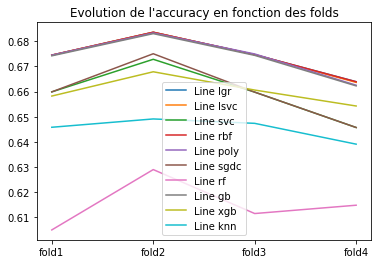

In [183]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross_8.shape[0]):
    plt.plot( df_cross_8.iloc[row,0:4] ,label='Line '+str(df_cross_8.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [184]:
for i in range(10):

    mean_model = df_cross_8.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross_8.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.6730932215927584 et un std : 0.007348161163587091
Le modèle N° 1 a une accuray de 0.6730381251740256 et un std : 0.007434736235101124
Le modèle N° 2 a une accuray de 0.6614141768199003 et un std : 0.010448317169061899
Le modèle N° 3 a une accuray de 0.6730932215927584 et un std : 0.007348161163587091
Le modèle N° 4 a une accuray de 0.6726524654167928 et un std : 0.007828024310247863
Le modèle N° 5 a une accuray de 0.6618548267785893 et un std : 0.011077015591023765
Le modèle N° 6 a une accuray de 0.6156344851079585 et un std : 0.008833484418159284
Le modèle N° 7 a une accuray de 0.6726524957645861 et un std : 0.007600203158259462
Le modèle N° 8 a une accuray de 0.6604779018749626 et un std : 0.004976369285951104
Le modèle N° 9 a une accuray de 0.645493390629967 et un std : 0.0038022018967980237


Le lgr est meilleur (de peu)

##### IV.2.3 - Grid Search

In [185]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [186]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300]  
}

c_lgr_8 = LogisticRegression(random_state=42)

In [187]:
grid_c_lgr_8 = GridSearchCV(c_lgr_8, param_grid=params, cv=5, return_train_score=True)

In [188]:
take_grid = grid_c_lgr_8.fit(X_train_resampled_sc_8, y_train_resampled_8)

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: Con

In [189]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))²

La meilleur combinaison d'estimateur est: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
pour un score de: 0.6796361369304013


Le `Grid Search` améliore très légèrement

##### IV.2.4 - Learning curve

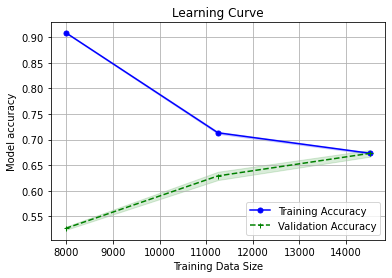

In [190]:
train_sizes, train_scores, test_scores = learning_curve(estimator=lgr, 
                                                        X=X_train_resampled_sc_8, 
                                                        y=y_train_resampled_8,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

On obtient une learning curve similaire au cas 1

#### IV.2.5 - Matrice de confusion

In [192]:
take_grid.best_params_

{'C': 0.1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [198]:
best_lgr_8 = LogisticRegression(C=0.1, class_weight=None, max_iter=100, penalty='l2', solver='liblinear')

In [199]:
best_lgr_8.fit(X_train_resampled_sc_8, y_train_resampled_8)

LogisticRegression(C=0.1, solver='liblinear')

In [204]:
print('Training score: ' + str(best_lgr_8.score(X_train_resampled_sc_8, y_train_resampled_8)), 
      '\n',
      'Test score: ' + str(best_lgr_8.score(X_test_sc_8, y_test_8))
     )

Training score: 0.6730938739532834 
 Test score: 0.7976712082107916


Encore une fois, le `GridSearch` n'améliore pas

In [ ]:
# Prédire les étiquettes sur l'ensemble de test et d'entraînement
y_pred_train = best_lgr_8.predict(X_train_resampled_sc_8)
y_pred_test = best_lgr_8.predict(X_test_sc_8)

# Calculer le score F1 pour l'ensemble d'entraînement et de test
f1_train = f1_score(y_train_resampled_8, y_pred_train)
f1_test = f1_score(y_test_8, y_pred_test)

# Afficher les scores F1
print('F1 Score (Entraînement): {:.4f}'.format(f1_train))
print('F1 Score (Test): {:.4f}'.format(f1_test))

In [298]:
best_lgr_8

LogisticRegression(C=0.1, solver='liblinear')

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

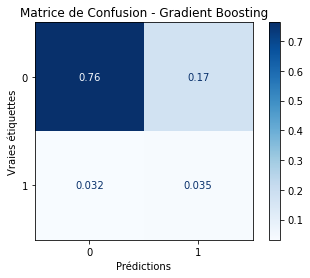

In [210]:
# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de confusion
confusion_matrix_disp = plot_confusion_matrix(best_lgr_8, X_test_sc_8, y_test_8,
                                               cmap=plt.cm.Blues, normalize='all')

# Personnaliser les étiquettes
confusion_matrix_disp.ax_.set_title('Matrice de Confusion - Gradient Boosting')
confusion_matrix_disp.ax_.set_xlabel('Prédictions')
confusion_matrix_disp.ax_.set_ylabel('Vraies étiquettes')

# Afficher le graphique
plt.show()

Encore une fois le modèle prédit mal les gens qui ont réellement une maladie cardiaque

In [209]:
# Prédire les étiquettes sur l'ensemble de test et d'entraînement
y_pred_train = best_lgr_8.predict(X_train_resampled_sc_8)
y_pred_test = best_lgr_8.predict(X_test_sc_8)

# Calculer le score F1 pour l'ensemble d'entraînement et de test
f1_train = f1_score(y_train_resampled_8, y_pred_train)
f1_test = f1_score(y_test_8, y_pred_test)

# Afficher les scores F1
print('F1 Score (Entraînement): {:.4f}'.format(f1_train))
print('F1 Score (Test): {:.4f}'.format(f1_test))

F1 Score (Entraînement): 0.6174
F1 Score (Test): 0.2563


F1 Score plutôt faible sur les données test

#### IV.2.6 - Importance des variables

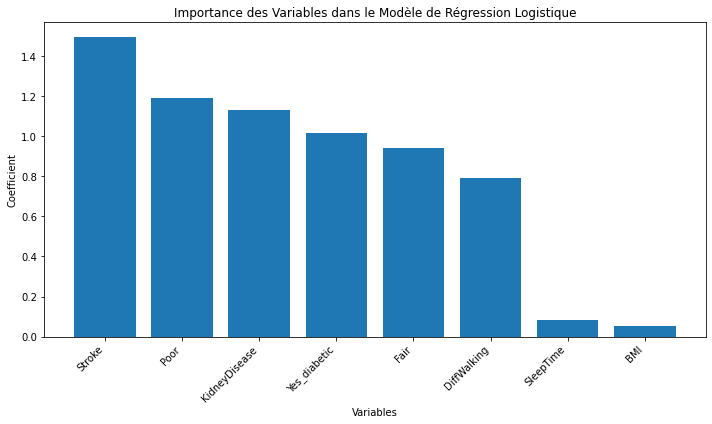

In [212]:
# Récupérer les coefficients du modèle
coefficients = best_lgr_8.coef_[0]

# Récupérer les noms des variables
feature_names = X_train_resampled_sc_8.columns

# Trier les indices par ordre décroissant des coefficients absolus
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[sorted_indices])
plt.xticks(range(len(coefficients)), np.array(feature_names)[sorted_indices], rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Importance des Variables dans le Modèle de Régression Logistique')
plt.tight_layout()
plt.show()


Les variables présente ici augmentent la probabilité de faire une maladie cardiaque

#### IV.3 - Modèle ré-échantillonné avec 15 variables

On refait l'analyse avec la deuxième feature selection

In [35]:
#Train and test
X_train_15 , X_test_15, y_train_15, y_test_15 = train_test_split(df_model_15.iloc[:,1:],
                                                     df_model_15.HeartDisease,
                                                     test_size=0.2)

# Appliquer l'échantillonnage stratifié uniquement sur l'ensemble d'entraînement
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled_15, y_train_resampled_15 = sampler.fit_resample(X_train_15, y_train_15)

In [36]:
# Sélection des variables à scaler
selected_features = ['BMI', 'SleepTime', 'PhysicalHealth', 'MentalHealth']

# Création d'un scaler
scaler = StandardScaler()

# Renommer les variables
X_train_resampled_sc_15 = X_train_resampled_15
X_test_sc_15 = X_test_15

# Calcul de la moyenne et de l'écart type sur X_train_resampled_sc_15 pour les variables sélectionnées
scaler.fit(X_train_resampled_sc_15[selected_features])

# Transformation des variables sélectionnées dans X_train_resampled_sc_15
X_train_resampled_sc_15[selected_features] = scaler.transform(X_train_resampled_sc_15[selected_features])

# Transformation des variables sélectionnées dans X_test_sc_15
X_test_sc_15[selected_features] = scaler.transform(X_test_sc_15[selected_features])

In [37]:
X_train_resampled_sc_15 = X_train_resampled_15.copy()
X_test_sc_15 = X_test_15.copy()

| Bases                  | Description                              |
|------------------------|------------------------------------------|
| X_train_resampled_sc_15 | X train ré-échantillonné 3e analyse    | 
| X_test_sc_15            | X test 3e analyse                       |
| y_train_resampled_15    | y train ré-échantillonné 3e analyse    |
| y_test_15              | y test 3e analyse                       |

In [219]:
X_train_resampled_sc_15.head(5)

,BMI,SleepTime,PhysicalHealth,MentalHealth,Smoking,DiffWalking,Sex,PhysicalActivity,Asthma,Excellent,Good,VeryGood,White,No_diabetic,Yes_diabetic
272756,-0.550227,1.055975,2.542323,0.050588,0,0,0,1,0,0,0,0,1,1,0
51191,-0.340994,-0.236188,-0.402035,-0.411853,0,0,1,1,0,0,0,1,1,1,0
72729,-0.319456,-1.528351,-0.402035,0.050588,0,0,0,1,0,1,0,0,1,1,0
313789,-1.122540,-1.528351,-0.402035,-0.411853,1,1,1,1,0,0,0,1,0,1,0
88450,-1.122540,1.055975,4.505228,-0.411853,1,0,0,1,0,0,0,1,1,1,0


In [220]:
X_test_sc_15.head(5)

,BMI,SleepTime,PhysicalHealth,MentalHealth,Smoking,DiffWalking,Sex,PhysicalActivity,Asthma,Excellent,Good,VeryGood,White,No_diabetic,Yes_diabetic
269705,0.311319,-1.528351,-0.402035,0.513029,0,1,0,1,0,0,1,0,1,0,0
202947,-0.645612,-0.236188,2.051597,4.212559,0,0,0,1,0,0,1,0,1,1,0
233464,0.492859,1.055975,-0.402035,-0.411853,1,0,1,1,0,1,0,0,0,1,0
36579,-0.454842,1.055975,-0.402035,-0.411853,1,0,1,1,0,0,1,0,0,0,0
198905,-0.565612,1.055975,-0.402035,-0.411853,0,0,1,1,0,1,0,0,1,1,0


##### IV.3.1 - Comparaisons

In [221]:
# Regression logistique
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_resampled_sc_15, y_train_resampled_15)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_resampled_sc_15, y_train_resampled_15)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_resampled_sc_15, y_train_resampled_15)

#SVM avec noyau RBF
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train_resampled_sc_15, y_train_resampled_15)

#SGD poly
svc_poly = SVC(kernel='poly',random_state=0)
svc_poly.fit(X_train_resampled_sc_15, y_train_resampled_15)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_resampled_sc_15, y_train_resampled_15)

#Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled_sc_15, y_train_resampled_15)

#Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled_sc_15, y_train_resampled_15)

#XGBoost
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_resampled_sc_15, y_train_resampled_15)

#K-Nearest Neighbors 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_resampled_sc_15, y_train_resampled_15)

KNeighborsClassifier()

##### IV.3.2 - Choix du modèle

In [222]:
# Get cross_val_score for each function

cvs_lgr_15 = cross_val_score(lgr, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_lsvc_15 = cross_val_score(l_SVC, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_svc_15 = cross_val_score(svc, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_rbf_15 = cross_val_score(rbf_svc, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_poly_15 = cross_val_score(svc_poly, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_sgdc_15 = cross_val_score(sgdc_svm, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_rf_15 = cross_val_score(rf_classifier, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_gb_15 = cross_val_score(gb_classifier, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_xgb_15 = cross_val_score(xgb_classifier, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

cvs_knn_15 = cross_val_score(knn_classifier, X_train_resampled_sc_15, y_train_resampled_15, cv=5, scoring='accuracy')

In [223]:
#Get data output from cross_val_score
df_cross_15 = pd.DataFrame(np.transpose(np.c_[cvs_lgr_15,cvs_lsvc_15,cvs_svc_15,cvs_rbf_15,cvs_poly_15,cvs_sgdc_15,cvs_rf_15,cvs_gb_15,cvs_xgb_15,cvs_knn_15]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])

#Adding model label
df_cross_15['model'] = ['lgr','lsvc','svc','rbf', 'poly', 'sgdc', 'rf', 'gb', 'xgb', 'knn']

In [224]:
df_cross_15

,fold1,fold2,fold3,fold4,fold5,model
0,0.717530,0.703683,0.700360,0.705899,0.713019,lgr
1,0.715591,0.705068,0.698698,0.707837,0.711357,lsvc
2,0.716699,0.700637,0.699252,0.703683,0.693352,svc
3,0.707283,0.693160,0.694268,0.707560,0.693906,rbf
4,0.708391,0.695929,0.691775,0.708391,0.695845,poly
5,0.701468,0.692329,0.698421,0.699806,0.697784,sgdc
6,0.652728,0.646081,0.639712,0.651620,0.640166,rf
7,0.714760,0.695929,0.698698,0.709222,0.706648,gb
8,0.685129,0.679036,0.685406,0.691221,0.692521,xgb
9,0.663251,0.659374,0.650235,0.658266,0.653463,knn


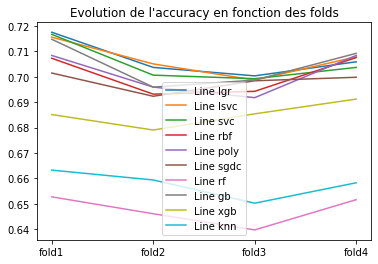

In [225]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross_15.shape[0]):
    plt.plot( df_cross_15.iloc[row,0:4] ,label='Line '+str(df_cross_15.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [226]:
for i in range(10):

    mean_model = df_cross_15.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross_15.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.7080982010185867 et un std : 0.007024645220497743
Le modèle N° 1 a une accuray de 0.7077104047267083 et un std : 0.006395757629113259
Le modèle N° 2 a une accuray de 0.7027246387039908 et un std : 0.008666987913562782
Le modèle N° 3 a une accuray de 0.6992353312554513 et un std : 0.007484465861400054
Le modèle N° 4 a une accuray de 0.7000662334464329 et un std : 0.007782712442087068
Le modèle N° 5 a une accuray de 0.6979616606997241 et un std : 0.003451979973319105
Le modèle N° 6 a une accuray de 0.6460614880202152 et un std : 0.006132044481974022
Le modèle N° 7 a une accuray de 0.7050516005649098 et un std : 0.007710131568385035
Le modèle N° 8 a une accuray de 0.6866625599986499 et un std : 0.005412782916595189
Le modèle N° 9 a une accuray de 0.6569179430963101 et un std : 0.00511265454782625


Encore une fois, le meilleur modèle est le modèle lgr

##### IV.3.3 - Grid Search

In [227]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300]  
}

c_lgr_15 = LogisticRegression(random_state=42)

In [228]:
grid_c_lgr_15 = GridSearchCV(c_lgr_15, param_grid=params, cv=5, return_train_score=True)

In [229]:
take_grid = grid_c_lgr_15.fit(X_train_resampled_sc_15, y_train_resampled_15)

In [230]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
pour un score de: 0.7082643446348531


Encore une fois, le `GridSearch` n'améliore pas

##### IV.3.4 - Learning curve

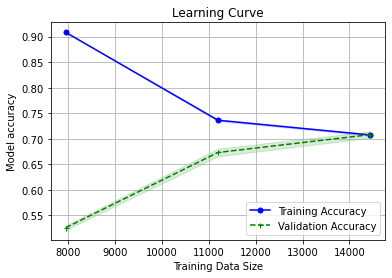

In [231]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_lgr_15, 
                                                        X=X_train_resampled_sc_15, 
                                                        y=y_train_resampled_15,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

La learning curve est similaire aux autres cas

##### IV.3.5 - Matrice de confusion

In [232]:
take_grid.best_params_

{'C': 1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [233]:
best_lgr_15 = LogisticRegression(C=1, class_weight=None, max_iter=100, penalty='l1', solver='liblinear')

In [234]:
best_lgr_15.fit(X_train_resampled_sc_15, y_train_resampled_15)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [237]:
print('Training score: ' + str(best_lgr_15.score(X_train_resampled_sc_15, y_train_resampled_15)), 
      '\n',
      'Test score: ' + str(best_lgr_15.score(X_test_sc_15, y_test_15))
     )

Training score: 0.7077655921125512 
 Test score: 0.7076105875997839


Le modèle ne semble pas être en sur-apprentissage, il semble être stable

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

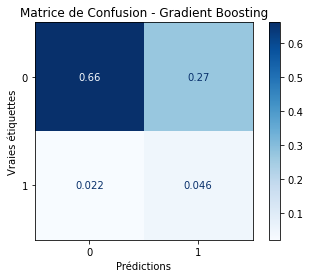

In [239]:
# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de confusion
confusion_matrix_disp = plot_confusion_matrix(best_lgr_15, X_test_sc_15, y_test_15,
                                               cmap=plt.cm.Blues, normalize='all')

# Personnaliser les étiquettes
confusion_matrix_disp.ax_.set_title('Matrice de Confusion - Gradient Boosting')
confusion_matrix_disp.ax_.set_xlabel('Prédictions')
confusion_matrix_disp.ax_.set_ylabel('Vraies étiquettes')

# Afficher le graphique
plt.show()

Le modèle prédit mal les cas de réelle maladie cardiaque

In [240]:
# Prédire les étiquettes sur l'ensemble de test et d'entraînement
y_pred_train = best_lgr_15.predict(X_train_resampled_sc_15)
y_pred_test = best_lgr_15.predict(X_test_sc_15)

# Calculer le score F1 pour l'ensemble d'entraînement et de test
f1_train = f1_score(y_train_resampled_15, y_pred_train)
f1_test = f1_score(y_test_15, y_pred_test)

# Afficher les scores F1
print('F1 Score (Entraînement): {:.4f}'.format(f1_train))
print('F1 Score (Test): {:.4f}'.format(f1_test))

F1 Score (Entraînement): 0.7038
F1 Score (Test): 0.2390


Encore une fois, le F1 score sur les données test est faible

##### IV.3.6 - Importance des variables

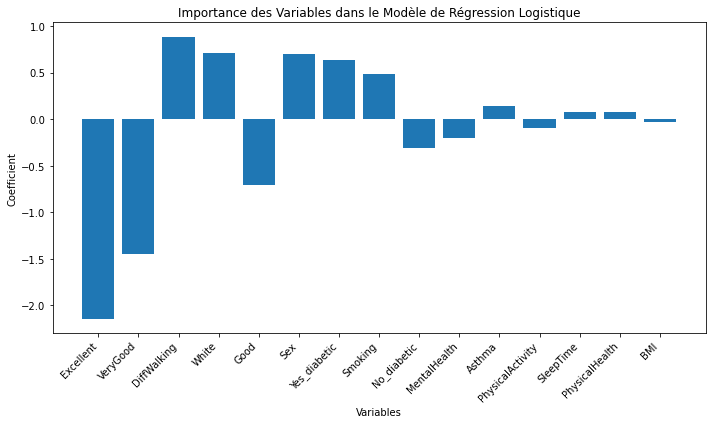

In [246]:
# Récupérer les coefficients du modèle
coefficients = best_lgr_15.coef_[0]

# Récupérer les noms des variables
feature_names = X_train_resampled_sc_15.columns

# Trier les indices par ordre décroissant des coefficients absolus
sorted_indices = np.argsort(np.abs(coefficients))[::-1]

# Tracer l'importance des variables
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[sorted_indices])
plt.xticks(range(len(coefficients)), np.array(feature_names)[sorted_indices], rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Importance des Variables dans le Modèle de Régression Logistique')
plt.tight_layout()
plt.show()

Le fait d'être en excellente santé ou très bonne diminue la prba de faire un arrêt cardiaque, au contraire le fait d'être blanc ou juste en bonne santé l'augmente

#### IV.4 - Modèle ré-échantillonné avec 9 variables

On modifie le threshold afin d'obtenir moins de variables

In [38]:
# Supprimer les caractéristiques avec une variance inférieure à un seuil
selector = VarianceThreshold(threshold=0.15)
X_selected = selector.fit_transform(qualis.drop("HeartDisease", axis=1), qualis["HeartDisease"])

# Récupérer les noms des caractéristiques sélectionnées
selected_feature_names = qualis.drop("HeartDisease", axis=1).columns[selector.get_support()]

# Afficher les noms des caractéristiques sélectionnées
print("Caractéristiques sélectionnées:", selected_feature_names.tolist())

Caractéristiques sélectionnées: ['Smoking', 'Sex', 'PhysicalActivity', 'Excellent', 'Good', 'VeryGood', 'White']


In [39]:
# Liste des variables à conserver
selected_variables = ['HeartDisease', 'BMI', 'SleepTime',
                       'Smoking', 'Sex', 'PhysicalActivity', 'Excellent', 'Good', 'VeryGood', 'White']

# Sélectionner les colonnes spécifiées dans un nouveau DataFrame
df_model_10 = df_without_outliers1[selected_variables].copy()

On supprime également les variables ayant des outliers

In [40]:
#Train and test
X_train_10 , X_test_10, y_train_10, y_test_10 = train_test_split(df_model_10.iloc[:,1:],
                                                     df_model_10.HeartDisease,
                                                     test_size=0.2)

# Appliquer l'échantillonnage stratifié uniquement sur l'ensemble d'entraînement
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled_10, y_train_resampled_10 = sampler.fit_resample(X_train_10, y_train_10)

# Sélection des variables à scaler
selected_features = ["BMI", "SleepTime"]

# Création d'un scaler
scaler = StandardScaler()

# Calcul de la moyenne et de l'écart type sur X_train_resampled pour les variables sélectionnées
scaler.fit(X_train_resampled[selected_features])

# Transformation des variables sélectionnées dans X_train_resampled
X_train_resampled_10[selected_features] = scaler.transform(X_train_resampled_10[selected_features])

# Transformation des variables sélectionnées dans X_test
X_test_10[selected_features] = scaler.transform(X_test_10[selected_features])

Je sais pas compter, on a 9 variables en tout

In [41]:
X_train_resampled_sc_10 = X_train_resampled_10.copy()
X_test_sc_10 = X_test_10.copy()

| Bases                  | Description                              |
|------------------------|------------------------------------------|
| X_train_resampled_sc_10 | X train ré-échantillonné 4e analyse    | 
| X_test_sc_10           | X test 4e analyse                       |
| y_train_resampled_10    | y train ré-échantillonné 4e analyse    |
| y_test_10               | y test 4e analyse                       |

##### IV.4.1 - Comparaisons

In [147]:
# Regression logistique
lgr = LogisticRegression(random_state=42)
lgr.fit(X_train_resampled_sc_10, y_train_resampled_10)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_resampled_sc_10, y_train_resampled_10)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_resampled_sc_10, y_train_resampled_10)

#SVM avec noyau RBF
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train_resampled_sc_10, y_train_resampled_10)

#SGD poly
svc_poly = SVC(kernel='poly',random_state=0)
svc_poly.fit(X_train_resampled_sc_10, y_train_resampled_10)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_resampled_sc_10, y_train_resampled_10)

#Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled_sc_10, y_train_resampled_10)

#Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled_sc_10, y_train_resampled_10)

#XGBoost
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_resampled_sc_10, y_train_resampled_10)

#K-Nearest Neighbors 
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_resampled_sc_10, y_train_resampled_10)

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KNeighborsClassifier()

##### IV.4.2 - Choix du modèle

In [148]:
# Get cross_val_score for each function

cvs_lgr_10 = cross_val_score(lgr, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_lsvc_10 = cross_val_score(l_SVC, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_svc_10 = cross_val_score(svc, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_rbf_10 = cross_val_score(rbf_svc, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_poly_10 = cross_val_score(svc_poly, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_sgdc_10 = cross_val_score(sgdc_svm, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_rf_10 = cross_val_score(rf_classifier, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_gb_10 = cross_val_score(gb_classifier, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_xgb_10 = cross_val_score(xgb_classifier, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

cvs_knn_10 = cross_val_score(knn_classifier, X_train_resampled_sc_10, y_train_resampled_10, cv=5, scoring='accuracy')

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [149]:
#Get data output from cross_val_score
df_cross_10 = pd.DataFrame(np.transpose(np.c_[cvs_lgr_10,cvs_lsvc_10,cvs_svc_10,cvs_rbf_10,cvs_poly_10,cvs_sgdc_10,cvs_rf_10,cvs_gb_10,cvs_xgb_10,cvs_knn_10]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross_10['model'] = ['lgr','lsvc','svc','rbf', 'poly', 'sgdc', 'rf', 'gb', 'xgb', 'knn']

In [150]:
df_cross_10

,fold1,fold2,fold3,fold4,fold5,model
0,0.676365,0.686617,0.678769,0.678492,0.672672,lgr
1,0.655860,0.650873,0.671286,0.677661,0.642184,lsvc
2,0.662510,0.668052,0.649667,0.655765,0.654933,svc
3,0.662510,0.668052,0.649667,0.655765,0.654933,rbf
4,0.663619,0.668606,0.649667,0.655765,0.654933,poly
5,0.500139,0.512330,0.679324,0.667960,0.636918,sgdc
6,0.601829,0.617346,0.605322,0.598670,0.604490,rf
7,0.676642,0.679135,0.680432,0.679878,0.683204,gb
8,0.666390,0.663342,0.658814,0.673226,0.670177,xgb
9,0.632308,0.647271,0.631652,0.634424,0.628326,knn


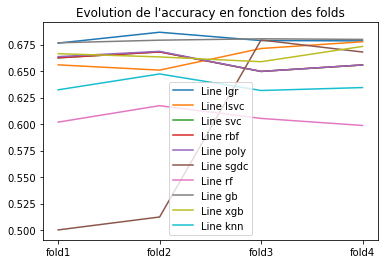

In [151]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross_10.shape[0]):
    plt.plot( df_cross_10.iloc[row,0:4] ,label='Line '+str(df_cross_10.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [152]:
for i in range(10):

    mean_model = df_cross_10.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross_10.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.6785829832907261 et un std : 0.005109982837512481
Le modèle N° 1 a une accuray de 0.6595727974962815 et un std : 0.014630575584469301
Le modèle N° 2 a une accuray de 0.658185667268144 et un std : 0.007159728593312504
Le modèle N° 3 a une accuray de 0.658185667268144 et un std : 0.007159728593312504
Le modèle N° 4 a une accuray de 0.6585181693462819 et un std : 0.0075258134866261215
Le modèle N° 5 a une accuray de 0.599334120353219 et un std : 0.08650120715377614
Le modèle N° 6 a une accuray de 0.6055310878998611 et un std : 0.007097457088948643
Le modèle N° 7 a une accuray de 0.6798583272048998 et un std : 0.0023660291087843396
Le modèle N° 8 a une accuray de 0.6663897044774121 et un std : 0.005651758186747714
Le modèle N° 9 a une accuray de 0.6347960322155931 et un std : 0.007309135668183556


Pour une fois le meilleur modèle est un gradient boosting

##### IV.4.3 - Grid Search

In [153]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [154]:
params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


c_gb_10 = GradientBoostingClassifier(random_state=42)

In [155]:
grid_c_gb_10 = GridSearchCV(c_gb_10, param_grid=params, cv=5, return_train_score=True)

In [156]:
take_grid = grid_c_gb_10.fit(X_train_resampled_sc_10, y_train_resampled_10)

In [157]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
pour un score de: 0.6822415198760919


Cette fois-ci le `OneHotEncoder` améliore le score

##### IV.4.3 - Learning curve

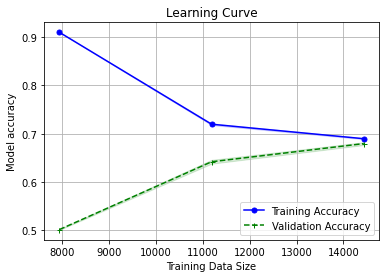

In [158]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_gb_10, 
                                                        X=X_train_resampled_sc_10, 
                                                        y=y_train_resampled_10,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )

#
# Trop de fluctuation dans le modèle, on calcule la moyenne des métriques
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()


La learning curve est similaire encore une fois

##### IV.4.4 - Matrice de confusion

In [159]:
take_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [162]:
best_gb_10 = GradientBoostingClassifier(learning_rate=0.1,
                                        max_depth=4,
                                        min_samples_leaf=2,
                                        min_samples_split=2,
                                        n_estimators=100)

In [163]:
best_gb_10.fit(X_train_resampled_sc_10, y_train_resampled_10)

GradientBoostingClassifier(max_depth=4, min_samples_leaf=2)

C:\Users\Chataigner\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x432 with 0 Axes>

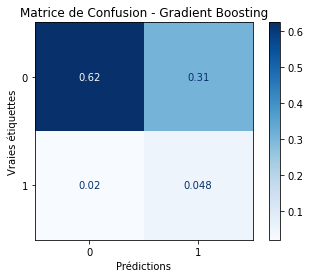

In [174]:
# Définir la taille de la figure
plt.figure(figsize=(8, 6))

# Tracer la matrice de confusion
confusion_matrix_disp = plot_confusion_matrix(best_gb_10, X_test_sc_10, y_test_10,
                                               cmap=plt.cm.Blues, normalize='all')

# Personnaliser les étiquettes
confusion_matrix_disp.ax_.set_title('Matrice de Confusion - Gradient Boosting')
confusion_matrix_disp.ax_.set_xlabel('Prédictions')
confusion_matrix_disp.ax_.set_ylabel('Vraies étiquettes')

# Afficher le graphique
plt.show()

Le modèle classe mal les individus ayant une réelle maladie cardiaque

In [194]:
print('Training score: ' + str(best_gb_10.score(X_train_resampled_sc_10, y_train_resampled_10)), 
      '\n',
      'Test score: ' + str(best_gb_10.score(X_test_sc_10, y_test_10))
     )

Training score: 0.6988693049551048 
 Test score: 0.672678710761659


Le modèle semble stable

In [208]:
# Prédire les étiquettes sur l'ensemble de test et d'entraînement
y_pred_train = best_gb_10.predict(X_train_resampled_sc_10)
y_pred_test = best_gb_10.predict(X_test_sc_10)

# Calculer le score F1 pour l'ensemble d'entraînement et de test
f1_train = f1_score(y_train_resampled_10, y_pred_train)
f1_test = f1_score(y_test_10, y_pred_test)

# Afficher les scores F1
print('F1 Score (Entraînement): {:.4f}'.format(f1_train))
print('F1 Score (Test): {:.4f}'.format(f1_test))

F1 Score (Entraînement): 0.7029
F1 Score (Test): 0.2282


##### IV.4.6 - Importance des variables

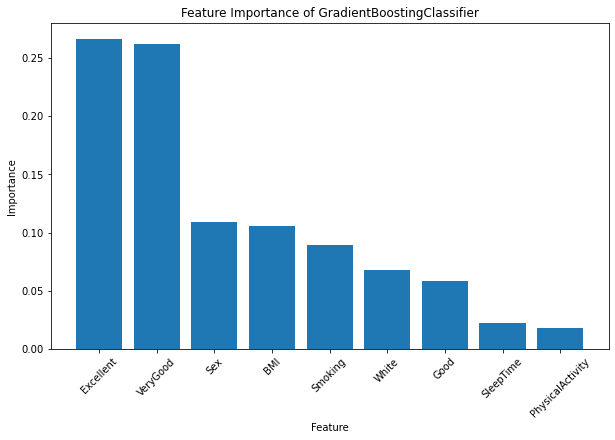

In [175]:
# Get feature importances
feature_importances = best_gb_10.feature_importances_

# Get actual feature names from your DataFrame (replace df with your DataFrame)
feature_names = X_train_resampled_sc_10.columns

# Sort indices based on feature importance
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance of GradientBoostingClassifier")
plt.show()

Les deux variables les plus importantes sont le fait d'être en excellente santé ou en très bonne santé

### V - Réseau de neurones

#### V.1 - Premier modèle 14 variables

##### V.1.1 - Modèle RN

In [296]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [298]:
#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train.shape[1]))#input layer
reg_model.add(keras.layers.Dense(100, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

In [301]:
history = reg_model.fit(X_train_resampled_sc, y_train_resampled, batch_size=2, epochs=30, validation_split=0.2)

Epoch 1/30
7230/7230 [==============================] - 33s 5ms/step - loss: 0.1955 - val_loss: 0.2302
Epoch 2/30
7230/7230 [==============================] - 32s 4ms/step - loss: 0.1900 - val_loss: 0.2714
Epoch 3/30
7230/7230 [==============================] - 29s 4ms/step - loss: 0.1902 - val_loss: 0.3132
Epoch 4/30
7230/7230 [==============================] - 31s 4ms/step - loss: 0.1895 - val_loss: 0.4247
Epoch 5/30
7230/7230 [==============================] - 32s 4ms/step - loss: 0.1892 - val_loss: 0.2964
Epoch 6/30
7230/7230 [==============================] - 30s 4ms/step - loss: 0.1893 - val_loss: 0.3573
Epoch 7/30
7230/7230 [==============================] - 27s 4ms/step - loss: 0.1895 - val_loss: 0.4170
Epoch 8/30
7230/7230 [==============================] - 28s 4ms/step - loss: 0.1892 - val_loss: 0.2498
Epoch 9/30
7230/7230 [==============================] - 31s 4ms/step - loss: 0.1888 - val_loss: 0.3292
Epoch 10/30
7230/7230 [==============================] - 30s 4ms/step - l

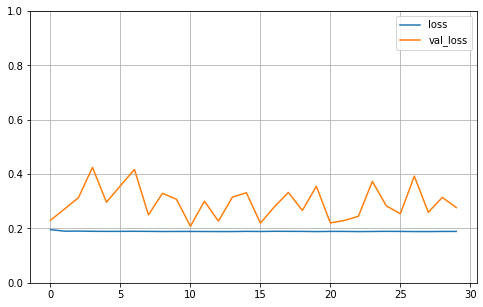

In [305]:
# Supposons que history.history est votre dictionnaire de données

# Convertir les données en DataFrame et tracer le graphique
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)

# Déterminer les limites de l'axe y pour être plus centré autour des valeurs inférieures à 5
plt.gca().set_ylim(0, 1) 

# Afficher le graphique
plt.show()

 La loss mesure la divergence des prédictions du modèle par rapport aux valeurs réelles sur l'ensemble d'entraînement, tandis que la val_loss évalue cette divergence sur un ensemble de validation distinct. La tendance à l'augmentation de la val_loss vers la fin des époques suggère un possible sur-entraînement, où le modèle devient trop spécifique aux données d'entraînement et perd sa capacité à généraliser correctement. L'écart croissant entre la loss et la val_loss renforce cette hypothèse

##### V.1.2 - Grid Search

In [310]:
# Define a function that creates your Keras model
def create_model(optimizer='adam', activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train.shape[1]))
    model.add(keras.layers.Dense(100, activation=activation))
    model.add(keras.layers.Dense(1))
    model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)
    return model

# Create a KerasRegressor based on your model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid to search
param_grid = {
    'batch_size': [4, 8],
    'epochs': [20, 30],
    'optimizer': ['adam'],
    'activation': ['relu']
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search_result = grid_search.fit(X_train_resampled_sc, y_train_resampled)

# Print the best parameters found
print("Best Parameters: ", grid_search_result.best_params_)

C:\Users\Chataigner\AppData\Local\Temp\ipykernel_8880\3009530116.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'activation': 'relu', 'batch_size': 8, 'epochs': 20, 'optimizer': 'adam'}


On fait un `Grid Search` directement sur le réseau de neurones

1042/1042 [==============================] - 3s 3ms/step
Matrice de confusion en %:
[[68.99945982 24.22123522]
 [ 2.12172139  4.65758358]]
Accuracy: 0.7365704339475422
F1 Score: 0.2612354822420468


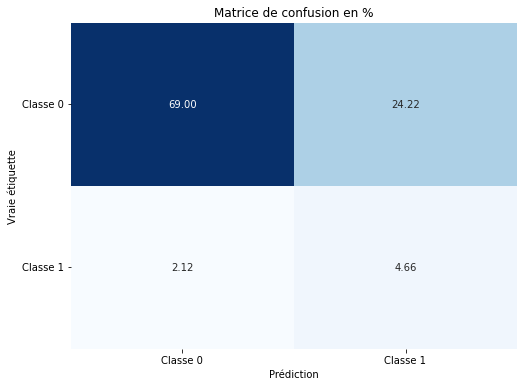

In [317]:
# Prédire les étiquettes sur les données de test
y_pred = best_model.predict(X_test_sc)

# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Calculer le nombre total d'échantillons dans les données de test
total_samples = len(y_test)

# Calculer la matrice de confusion en pourcentage
conf_matrix_percent = conf_matrix / total_samples * 100

print("Matrice de confusion en %:")
print(conf_matrix_percent)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Calculer le F1 score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

# Créer une figure et un axe
plt.figure(figsize=(8, 6))

# Créer un heatmap pour la matrice de confusion
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)

# Ajouter des titres et des étiquettes
plt.title('Matrice de confusion en %')
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'], rotation=0)

# Afficher le graphique
plt.show()

Rebelote, il classe bien les gens qui n'ont pas de maladie cardiaque mais classe mal ceux qui en ont réellement

#### V.2 - Deuxième modèle 8 variables

###### V.2.1 - Modèle RN

In [319]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train_8.shape[1]))#input layer
reg_model.add(keras.layers.Dense(100, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

history = reg_model.fit(X_train_resampled_sc_8, y_train_resampled_8, batch_size=2, epochs=30, validation_split=0.2)

Epoch 1/30
7198/7198 [==============================] - 33s 4ms/step - loss: 0.2097 - val_loss: 0.3288
Epoch 2/30
7198/7198 [==============================] - 31s 4ms/step - loss: 0.2049 - val_loss: 0.2754
Epoch 3/30
7198/7198 [==============================] - 29s 4ms/step - loss: 0.2047 - val_loss: 0.2493
Epoch 4/30
7198/7198 [==============================] - 32s 4ms/step - loss: 0.2051 - val_loss: 0.3799
Epoch 5/30
7198/7198 [==============================] - 26s 4ms/step - loss: 0.2057 - val_loss: 0.3303
Epoch 6/30
7198/7198 [==============================] - 29s 4ms/step - loss: 0.2056 - val_loss: 0.3250
Epoch 7/30
7198/7198 [==============================] - 31s 4ms/step - loss: 0.2059 - val_loss: 0.3364
Epoch 8/30
7198/7198 [==============================] - 29s 4ms/step - loss: 0.2059 - val_loss: 0.3040
Epoch 9/30
7198/7198 [==============================] - 32s 4ms/step - loss: 0.2053 - val_loss: 0.3137
Epoch 10/30
7198/7198 [==============================] - 31s 4ms/step - l

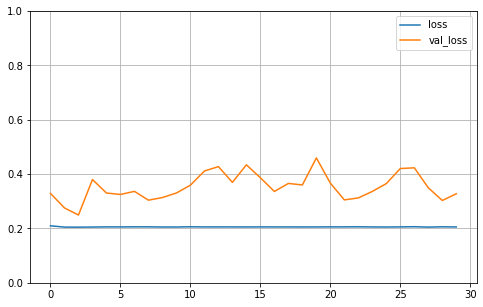

In [320]:
# Supposons que history.history est votre dictionnaire de données

# Convertir les données en DataFrame et tracer le graphique
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)

# Déterminer les limites de l'axe y pour être plus centré autour des valeurs inférieures à 5
plt.gca().set_ylim(0, 1) 

# Afficher le graphique
plt.show()

##### V.2.2 - Grid Search

In [321]:
# Define a function that creates your Keras model
def create_model(optimizer='adam', activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train_8.shape[1]))
    model.add(keras.layers.Dense(100, activation=activation))
    model.add(keras.layers.Dense(1))
    model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)
    return model

# Create a KerasRegressor based on your model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid to search
param_grid = {
    'batch_size': [4, 8],
    'epochs': [20, 30],
    'optimizer': ['adam'],
    'activation': ['relu']
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search_result = grid_search.fit(X_train_resampled_sc_8, y_train_resampled_8)

# Print the best parameters found
print("Best Parameters: ", grid_search_result.best_params_)

C:\Users\Chataigner\AppData\Local\Temp\ipykernel_8880\574039108.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'activation': 'relu', 'batch_size': 8, 'epochs': 30, 'optimizer': 'adam'}


In [326]:

# Obtenir le meilleur modèle de la recherche sur grille
best_model = grid_search_result.best_estimator_

# Prédire les étiquettes sur les données de test
y_pred = best_model.predict(X_test_sc_8)

# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_8, y_pred_binary)

# Calculer l'accuracy
accuracy = accuracy_score(y_test_8, y_pred_binary)

# Calculer le F1 score
f1 = f1_score(y_test_8, y_pred_binary)

# Afficher les résultats
print("Matrice de confusion:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Matrice de confusion:
[[25398  5625]
 [ 1115  1184]]
Accuracy: 0.79773122861773
F1 Score: 0.25999121651295565


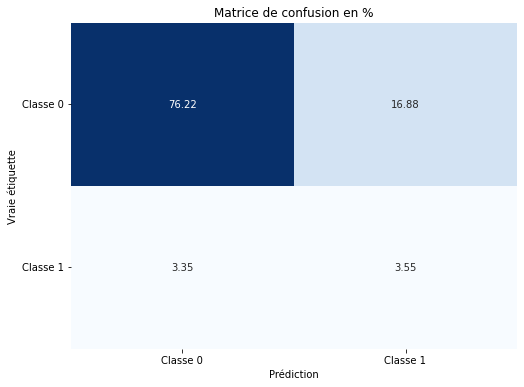

In [328]:
# Calculer le nombre total d'échantillons dans les données de test
total_samples = len(y_test_8)

# Calculer la matrice de confusion en pourcentage
conf_matrix_percent = conf_matrix / total_samples * 100

# Créer une figure et un axe
plt.figure(figsize=(8, 6))

# Créer un heatmap pour la matrice de confusion en pourcentage
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)

# Ajouter des titres et des étiquettes
plt.title('Matrice de confusion en %')
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'], rotation=0)

# Afficher le graphique
plt.show()


#### V.3 - Premier modèle 15 variables

##### V.3.1 - Modèle RN

In [43]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train_15.shape[1]))#input layer
reg_model.add(keras.layers.Dense(100, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

history = reg_model.fit(X_train_resampled_sc_15, y_train_resampled_15, batch_size=2, epochs=30, validation_split=0.2)

Epoch 1/30
7212/7212 [==============================] - 10s 1ms/step - loss: 0.2029 - val_loss: 0.3909
Epoch 2/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0.1938 - val_loss: 0.3068
Epoch 3/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0.1933 - val_loss: 0.2771
Epoch 4/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0.1933 - val_loss: 0.2814
Epoch 5/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0.1935 - val_loss: 0.2249
Epoch 6/30
7212/7212 [==============================] - 10s 1ms/step - loss: 0.1930 - val_loss: 0.2461
Epoch 7/30
7212/7212 [==============================] - 10s 1ms/step - loss: 0.1938 - val_loss: 0.2924
Epoch 8/30
7212/7212 [==============================] - 10s 1ms/step - loss: 0.1937 - val_loss: 0.3432
Epoch 9/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0.1936 - val_loss: 0.2285
Epoch 10/30
7212/7212 [==============================] - 9s 1ms/step - loss: 0

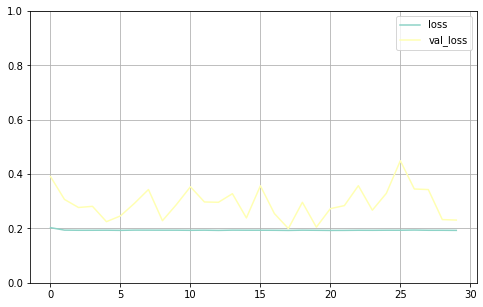

In [48]:
# Supposons que history.history est votre dictionnaire de données

# Convertir les données en DataFrame et tracer le graphique
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)

# Déterminer les limites de l'axe y pour être plus centré autour des valeurs inférieures à 5
plt.gca().set_ylim(0, 1) 

# Afficher le graphique
plt.show()

In [64]:
# Perte finale sur les données d'entraînement et de validation
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("Perte finale sur les données d'entraînement (MSE) :", final_train_loss)
print("Perte finale sur les données de validation (MSE) :", final_val_loss)

Perte finale sur les données d'entraînement (MSE) : 0.2052239030599594
Perte finale sur les données de validation (MSE) : 0.18988138437271118


##### V.3.2 - Grid Search

In [44]:
# Define a function that creates your Keras model
def create_model(optimizer='adam', activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train_15.shape[1]))
    model.add(keras.layers.Dense(100, activation=activation))
    model.add(keras.layers.Dense(1))
    model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)
    return model

# Create a KerasRegressor based on your model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid to search
param_grid = {
    'batch_size': [4, 8],
    'epochs': [20, 30],
    'optimizer': ['adam'],
    'activation': ['relu']
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search_result = grid_search.fit(X_train_resampled_sc_15, y_train_resampled_15)

# Print the best parameters found
print("Best Parameters: ", grid_search_result.best_params_)

C:\Users\Chataigner\AppData\Local\Temp\ipykernel_25588\1350824216.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'activation': 'relu', 'batch_size': 4, 'epochs': 30, 'optimizer': 'adam'}


In [45]:
# Obtenir le meilleur modèle de la recherche sur grille
best_model = grid_search_result.best_estimator_

# Prédire les étiquettes sur les données de test
y_pred = best_model.predict(X_test_sc_15)

# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_15, y_pred_binary)

# Calculer l'accuracy
accuracy = accuracy_score(y_test_15, y_pred_binary)

# Calculer le F1 score
f1 = f1_score(y_test_15, y_pred_binary)

# Afficher les résultats
print("Matrice de confusion:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Matrice de confusion:
[[21888  9152]
 [  703  1579]]
Accuracy: 0.7042494448112359
F1 Score: 0.2426803965265504


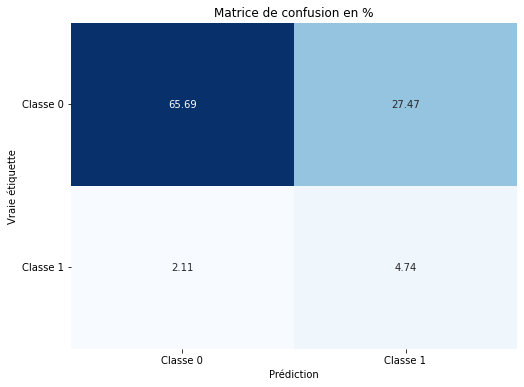

In [46]:
# Calculer le nombre total d'échantillons dans les données de test
total_samples = len(y_test_15)

# Calculer la matrice de confusion en pourcentage
conf_matrix_percent = conf_matrix / total_samples * 100

# Créer une figure et un axe
plt.figure(figsize=(8, 6))

# Créer un heatmap pour la matrice de confusion en pourcentage
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)

# Ajouter des titres et des étiquettes
plt.title('Matrice de confusion en %')
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'], rotation=0)

# Afficher le graphique
plt.show()

#### V.4 - Premier modèle 9 variables

##### V.4.1 - Modèle RN

In [49]:
#Clear session and set seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Initialisation du modèle
reg_model = keras.models.Sequential()
#Shape input, number of columns
reg_model.add(keras.layers.Input(shape=X_train_10.shape[1]))#input layer
reg_model.add(keras.layers.Dense(100, activation='relu'))#Hidden layer, 100 neurones
reg_model.add(keras.layers.Dense(1))#Output layer

#Compil model parameter²
reg_model.compile(loss=keras.losses.mean_squared_error, 
                  optimizer=keras.optimizers.Adam(learning_rate=0.01)
                 )
#Fit model

history = reg_model.fit(X_train_resampled_sc_10, y_train_resampled_10, batch_size=2, epochs=30, validation_split=0.2)

Epoch 1/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2297 - val_loss: 0.2585
Epoch 2/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2062 - val_loss: 0.1879
Epoch 3/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2063 - val_loss: 0.2969
Epoch 4/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2054 - val_loss: 0.2460
Epoch 5/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2047 - val_loss: 0.2999
Epoch 6/30
7192/7192 [==============================] - 10s 1ms/step - loss: 0.2048 - val_loss: 0.3230
Epoch 7/30
7192/7192 [==============================] - 10s 1ms/step - loss: 0.2059 - val_loss: 0.2616
Epoch 8/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2051 - val_loss: 0.4353
Epoch 9/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2044 - val_loss: 0.1956
Epoch 10/30
7192/7192 [==============================] - 9s 1ms/step - loss: 0.2

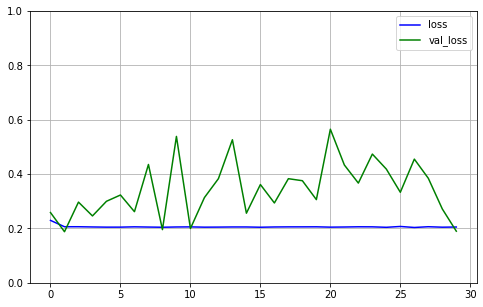

In [54]:
# Convertir les données en DataFrame et tracer le graphique
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5), color=['blue', 'green'])  # Spécifiez les couleurs que vous souhaitez pour chaque courbe
plt.grid(True)

# Déterminer les limites de l'axe y pour être plus centré autour des valeurs inférieures à 5
plt.gca().set_ylim(0, 1) 

# Afficher le graphique
plt.show()

In [56]:
#On change couleurs pcq sur l'autre on voyait pas trop

##### V.4.2 - Grid Search

In [55]:
# Define a function that creates your Keras model
def create_model(optimizer='adam', activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train_10.shape[1]))
    model.add(keras.layers.Dense(100, activation=activation))
    model.add(keras.layers.Dense(1))
    model.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer)
    return model

# Create a KerasRegressor based on your model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid to search
param_grid = {
    'batch_size': [4, 8],
    'epochs': [20, 30],
    'optimizer': ['adam'],
    'activation': ['relu']
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_search_result = grid_search.fit(X_train_resampled_sc_10, y_train_resampled_10)

# Print the best parameters found
print("Best Parameters: ", grid_search_result.best_params_)

C:\Users\Chataigner\AppData\Local\Temp\ipykernel_25588\3350158401.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Parameters:  {'activation': 'relu', 'batch_size': 4, 'epochs': 20, 'optimizer': 'adam'}


In [57]:
# Obtenir le meilleur modèle de la recherche sur grille
best_model = grid_search_result.best_estimator_

# Prédire les étiquettes sur les données de test
y_pred = best_model.predict(X_test_sc_10)

# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_10, y_pred_binary)

# Calculer l'accuracy
accuracy = accuracy_score(y_test_10, y_pred_binary)

# Calculer le F1 score
f1 = f1_score(y_test_10, y_pred_binary)

# Afficher les résultats
print("Matrice de confusion:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Matrice de confusion:
[[20427 10588]
 [  684  1623]]
Accuracy: 0.6617249864954085
F1 Score: 0.22358451577352254


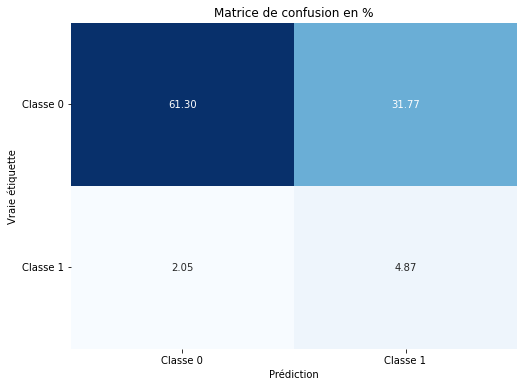

In [58]:
# Calculer le nombre total d'échantillons dans les données de test
total_samples = len(y_test_15)

# Calculer la matrice de confusion en pourcentage
conf_matrix_percent = conf_matrix / total_samples * 100

# Créer une figure et un axe
plt.figure(figsize=(8, 6))

# Créer un heatmap pour la matrice de confusion en pourcentage
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)

# Ajouter des titres et des étiquettes
plt.title('Matrice de confusion en %')
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.xticks([0.5, 1.5], ['Classe 0', 'Classe 1'])
plt.yticks([0.5, 1.5], ['Classe 0', 'Classe 1'], rotation=0)

# Afficher le graphique
plt.show()

Nous nous sommes en parti inspiré des codes disponibles ici :
* https://github.com/Roulitoo/cours_iae/blob/master/01_SVM/td/code/01_SVM_TD_correction.ipynb
* https://github.com/Roulitoo/cours_iae/blob/master/02_ANN/td/td_ann_02_correction_q3.ipynb